In [1]:
%matplotlib inline
import sys
sys.path.append("../lib/")
import os
import string
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import shap

from raman_lib.visualization import (plot_spectra_peaks, 
                                     plot_qc_summary, 
                                     plot_confidence_scores, 
                                     plot_coefs, 
                                     plot_confusion_matrix, 
                                     plot_roc_curve, 
                                     plot_validation_curve, 
                                     plot_params,
                                     plot_roc_comparison,
                                     boxplot_comparison)

# Setup

In [2]:
dataset = "L_540_2022_C_E"

In [3]:
results_path = Path("../results/") / dataset
img_path = Path("../img/") / dataset

img_path.mkdir(parents=True, exist_ok=True)

In [4]:
data = pd.read_csv(results_path / (dataset + "_preprocessed.csv"))

y, y_key = pd.factorize(data.label)

In [5]:
rocs = {}
aucs = {}
p_vals = {}
accs = {}
f1_scores = {}
fit_times = {}
predict_times = {}

In [6]:
plt.style.use("seaborn-paper")
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["figure.dpi"] = 200

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 11
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["legend.fontsize"] = 12

# Quality Control

In [7]:
qc_results = pd.read_csv(results_path / (dataset + "_qc_scores.csv"))

qc_results.describe()

Median Height     N Peaks
count     644.000000  644.000000
mean      499.795421   11.905280
std       409.446582    7.186823
min         0.000000    0.000000
25%       251.732071    5.750000
50%       377.522729   13.000000
75%       622.191017   18.000000
max      3384.882316   27.000000

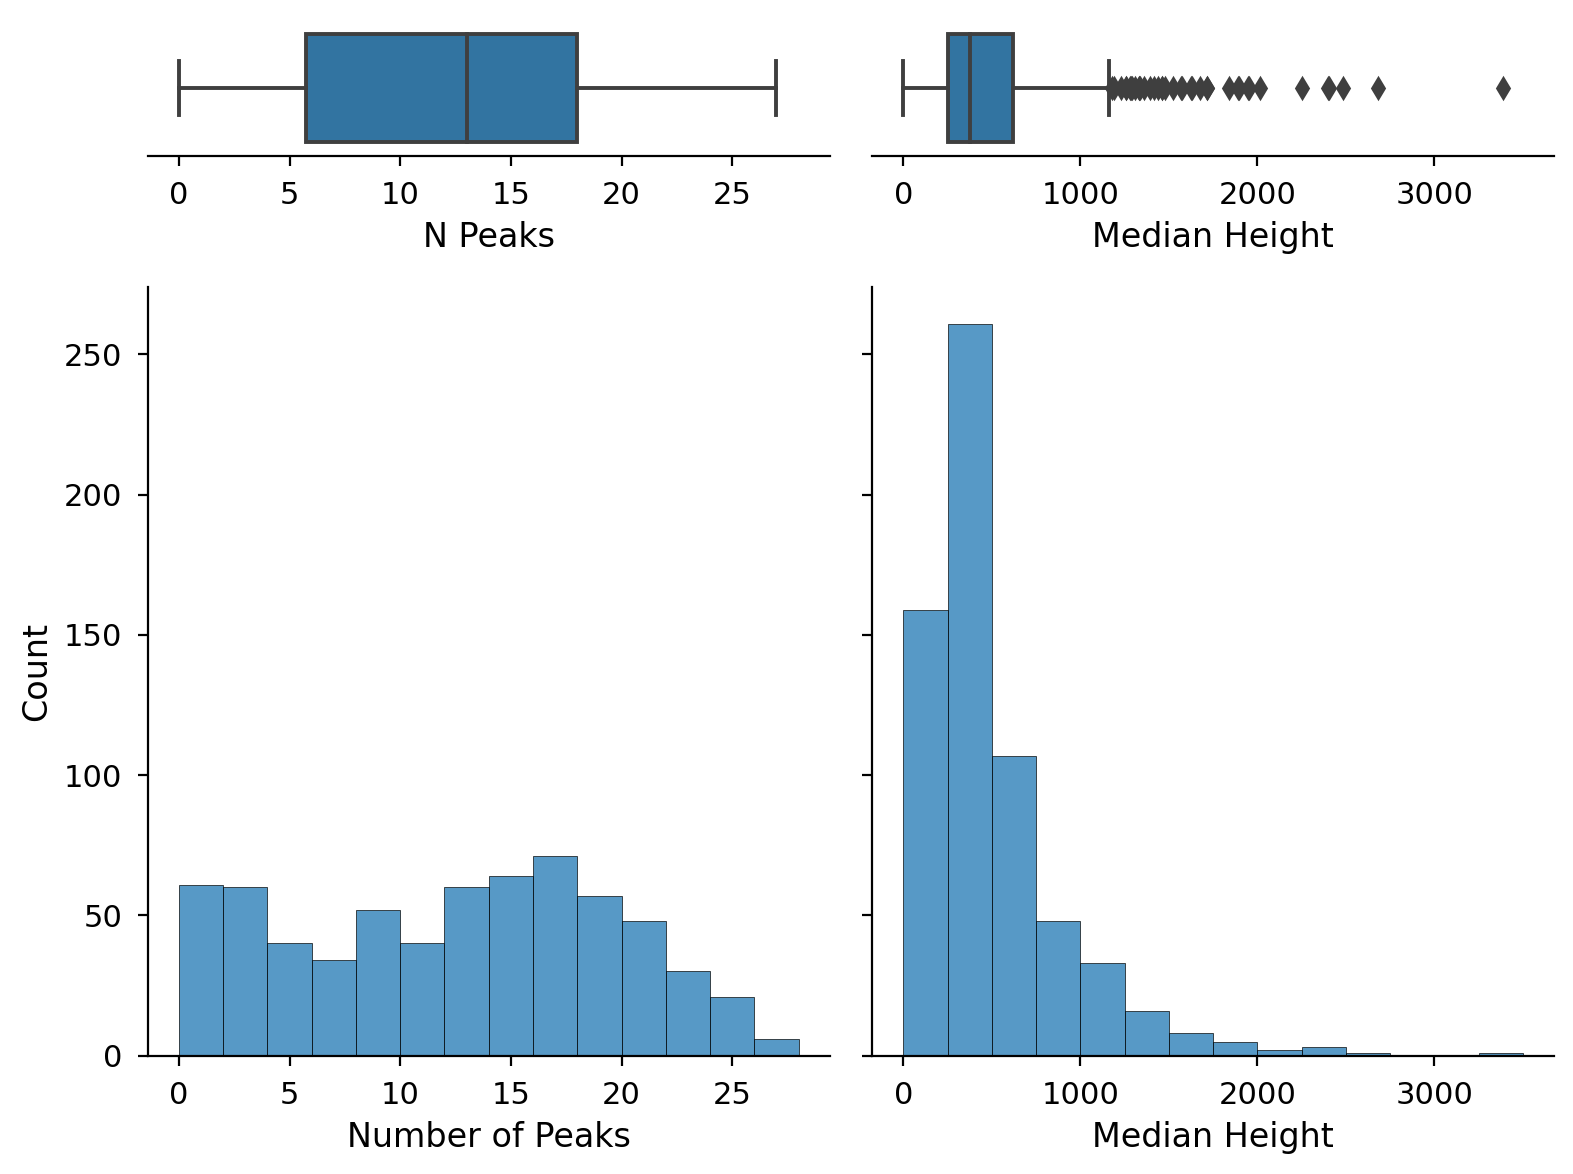

In [8]:
fig, ((ax_box1, ax_box2), (ax_hist1, ax_hist2)) = plt.subplots(
    2, 2, sharex="col", sharey="row", gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x=qc_results.iloc[:,1], ax=ax_box1)
sns.boxplot(x=qc_results.iloc[:,0], ax=ax_box2)
sns.histplot(qc_results.iloc[:,1], ax=ax_hist1, binrange=None, binwidth=2)
sns.histplot(qc_results.iloc[:,0], ax=ax_hist2, binrange=None, binwidth=250)

ax_box1.set(yticks=[])
ax_box2.set(yticks=[])
sns.despine(ax=ax_hist1)
sns.despine(ax=ax_hist2)
sns.despine(ax=ax_box1, left=True)
sns.despine(ax=ax_box2, left=True)

ax_hist1.set_xlabel("Number of Peaks")
ax_hist2.set_xlabel(qc_results.columns[0])

#ax_hist1.set_ylim([None, ymax_peaks])
#ax_hist2.set_ylim([None, ymax_score])

ax_box1.tick_params(axis="x", labelbottom=True)
ax_box2.tick_params(axis="x", labelbottom=True)

fig.tight_layout()

# Dimensionality Reduction
## LDA
### Overview

In [9]:
current_path = results_path / "lda_dim_reduction/lda/"
name = "LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_roc_auc  test_roc_auc  train_accuracy  test_accuracy   train_f1  \
count      20.000000     20.000000       20.000000      20.000000  20.000000   
mean        1.000000      0.732783        0.999708       0.682667   0.999708   
std         0.000001      0.011817        0.000408       0.012036   0.000408   
min         0.999997      0.706222        0.998750       0.663333   0.998749   
25%         1.000000      0.725472        0.999479       0.677500   0.999479   
50%         1.000000      0.733778        1.000000       0.680000   1.000000   
75%         1.000000      0.739722        1.000000       0.688750   1.000000   
max         1.000000      0.753111        1.000000       0.706667   1.000000   

         test_f1   fit_time  predict_time       p_value  
count  20.000000  20.000000     20.000000  2.000000e+01  
mean    0.688352   0.431106      0.004809  6.088197e-09  
std     0.014791   0.029528      0.001650  1.602079e-08  
min     0.660353   0.381089      0.003217  2.829740e-12  
25%     0.678192   0.411980      0.003803  3.365343e-10  
50%     0.688791   0.420401      0.004039  1.018173e-09  
75%     0.698518   0.446635      0.005211  3.070974e-09  
max     0.716390   0.497931      0.008925  7.181610e-08

### Confidence scores by class

Text(0, 0.5, 'Confidence score (-)')

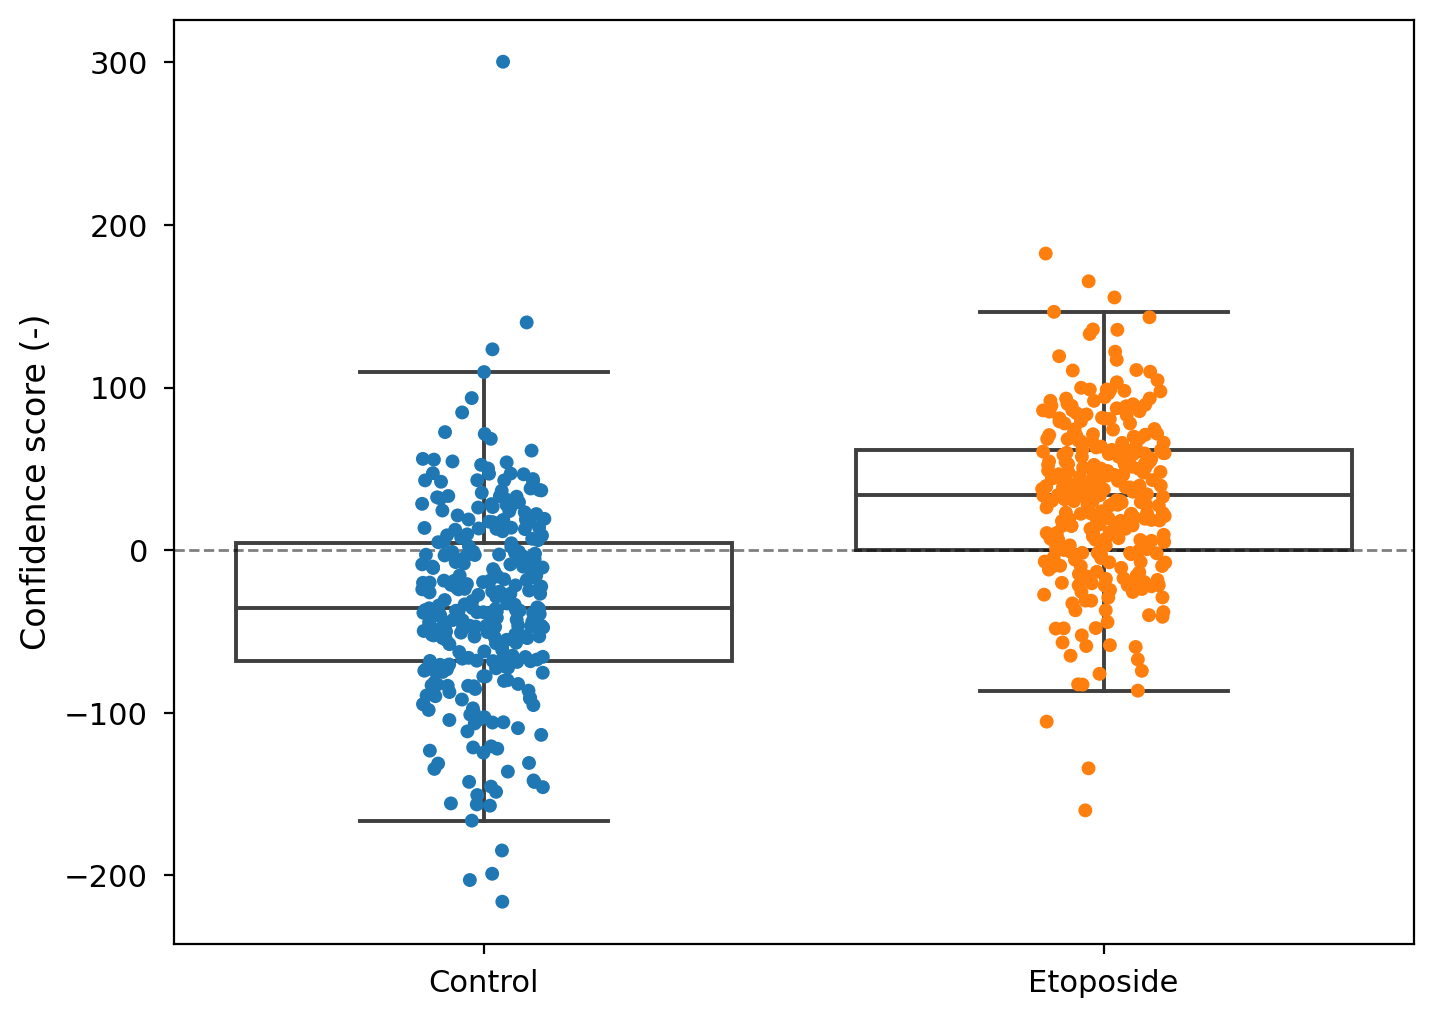

In [10]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)

fig, ax = plt.subplots()
ax.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.5)
plot_confidence_scores(conf_score_df, y_key[y], y_key, ax=ax)
ax.set_ylabel("Confidence score (-)")

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

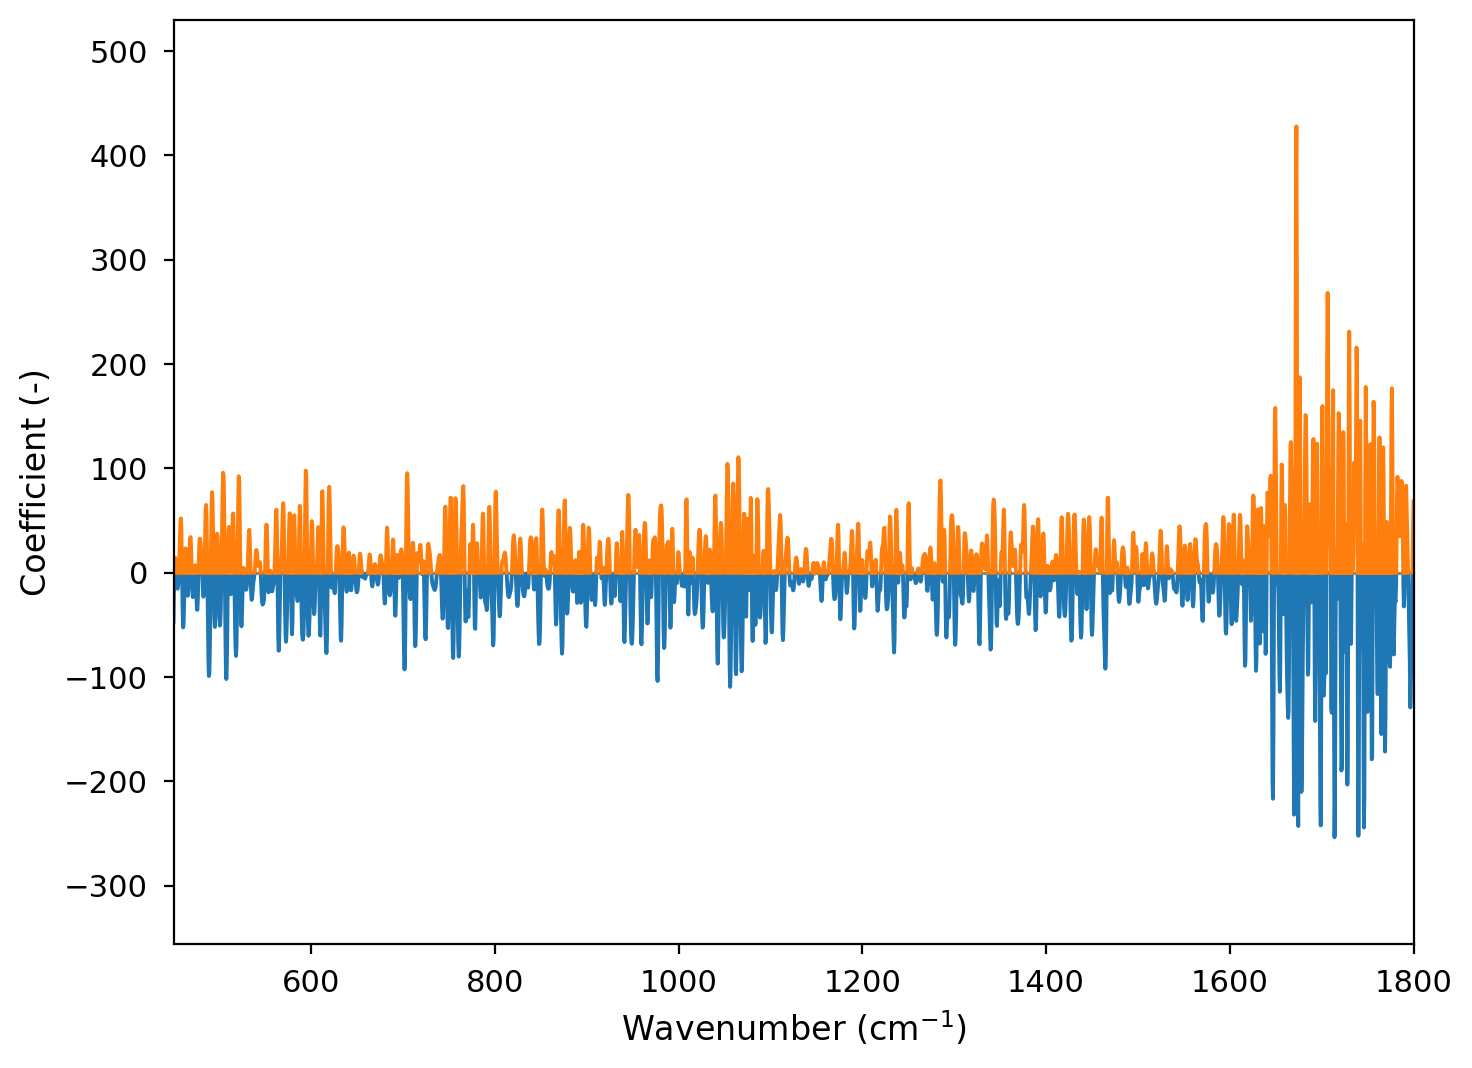

In [11]:
coef_df = pd.read_csv(current_path / "coefficients.csv")

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax)

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)

### Confusion Matrix

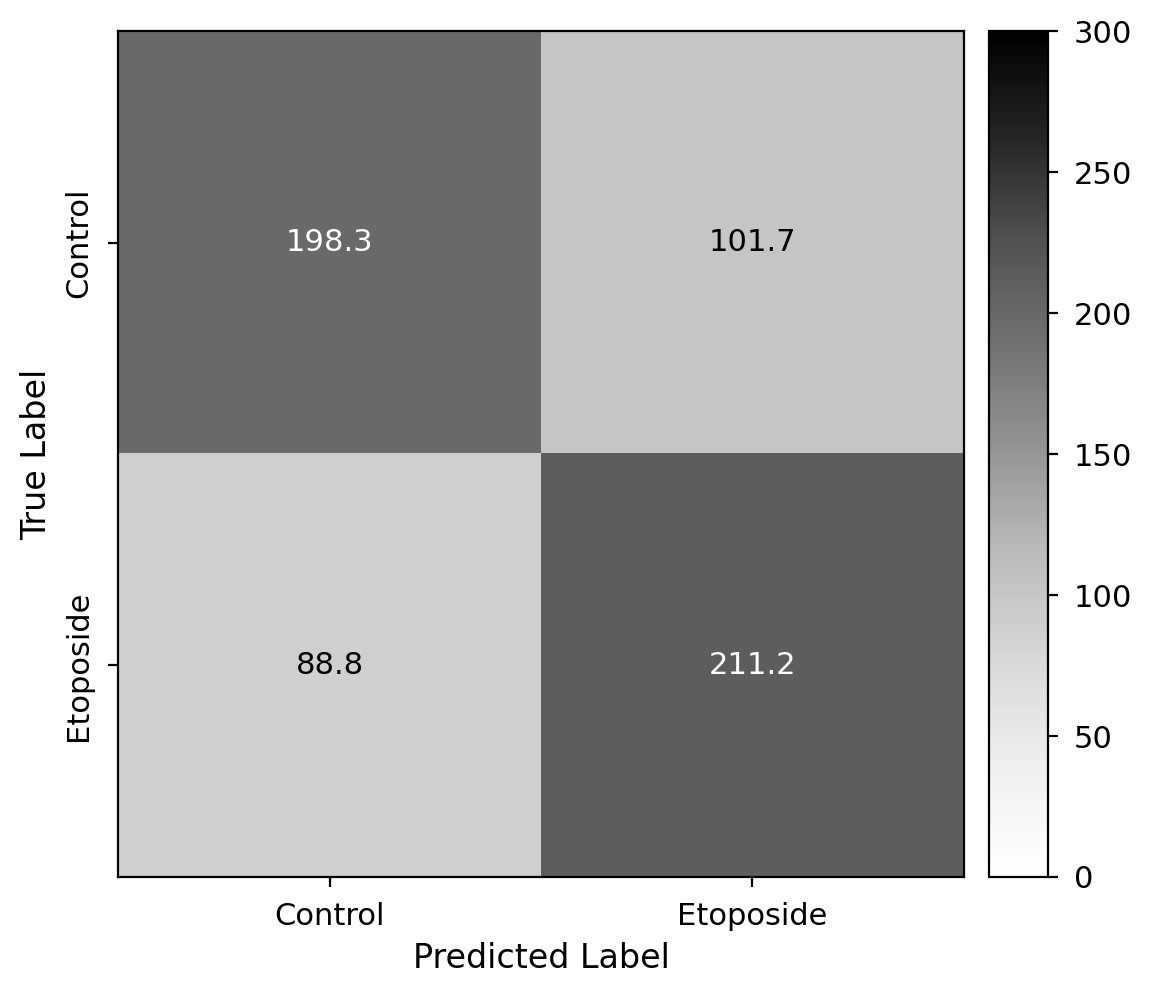

In [12]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

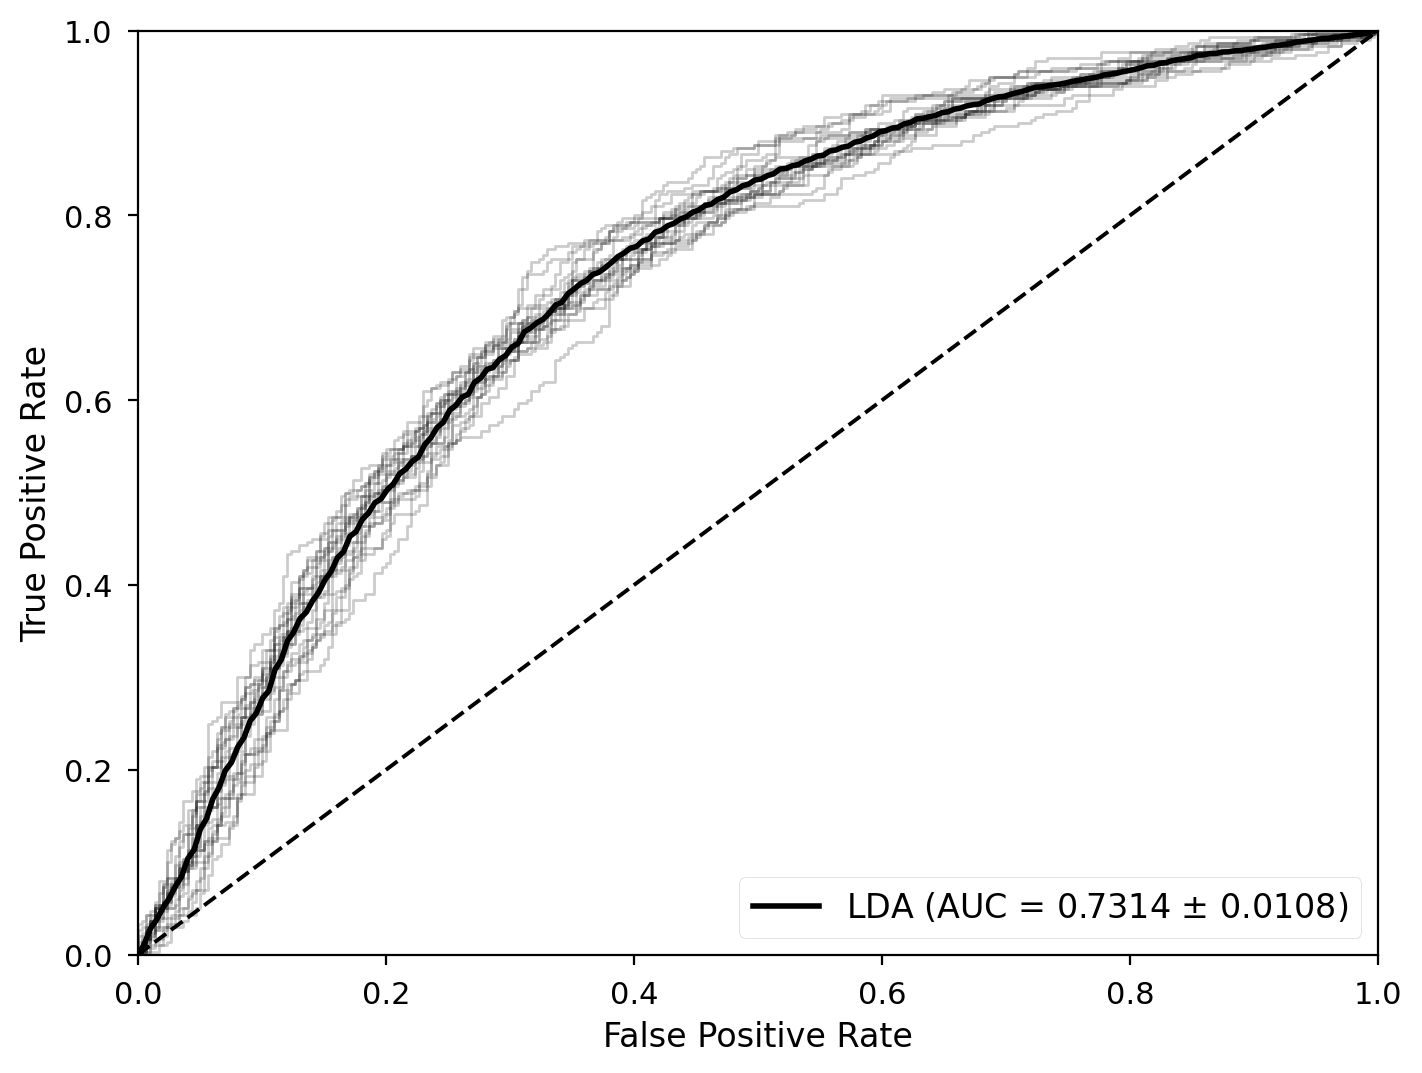

In [13]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(conf_score_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")

rocs[name] = roc
aucs[name] = auc

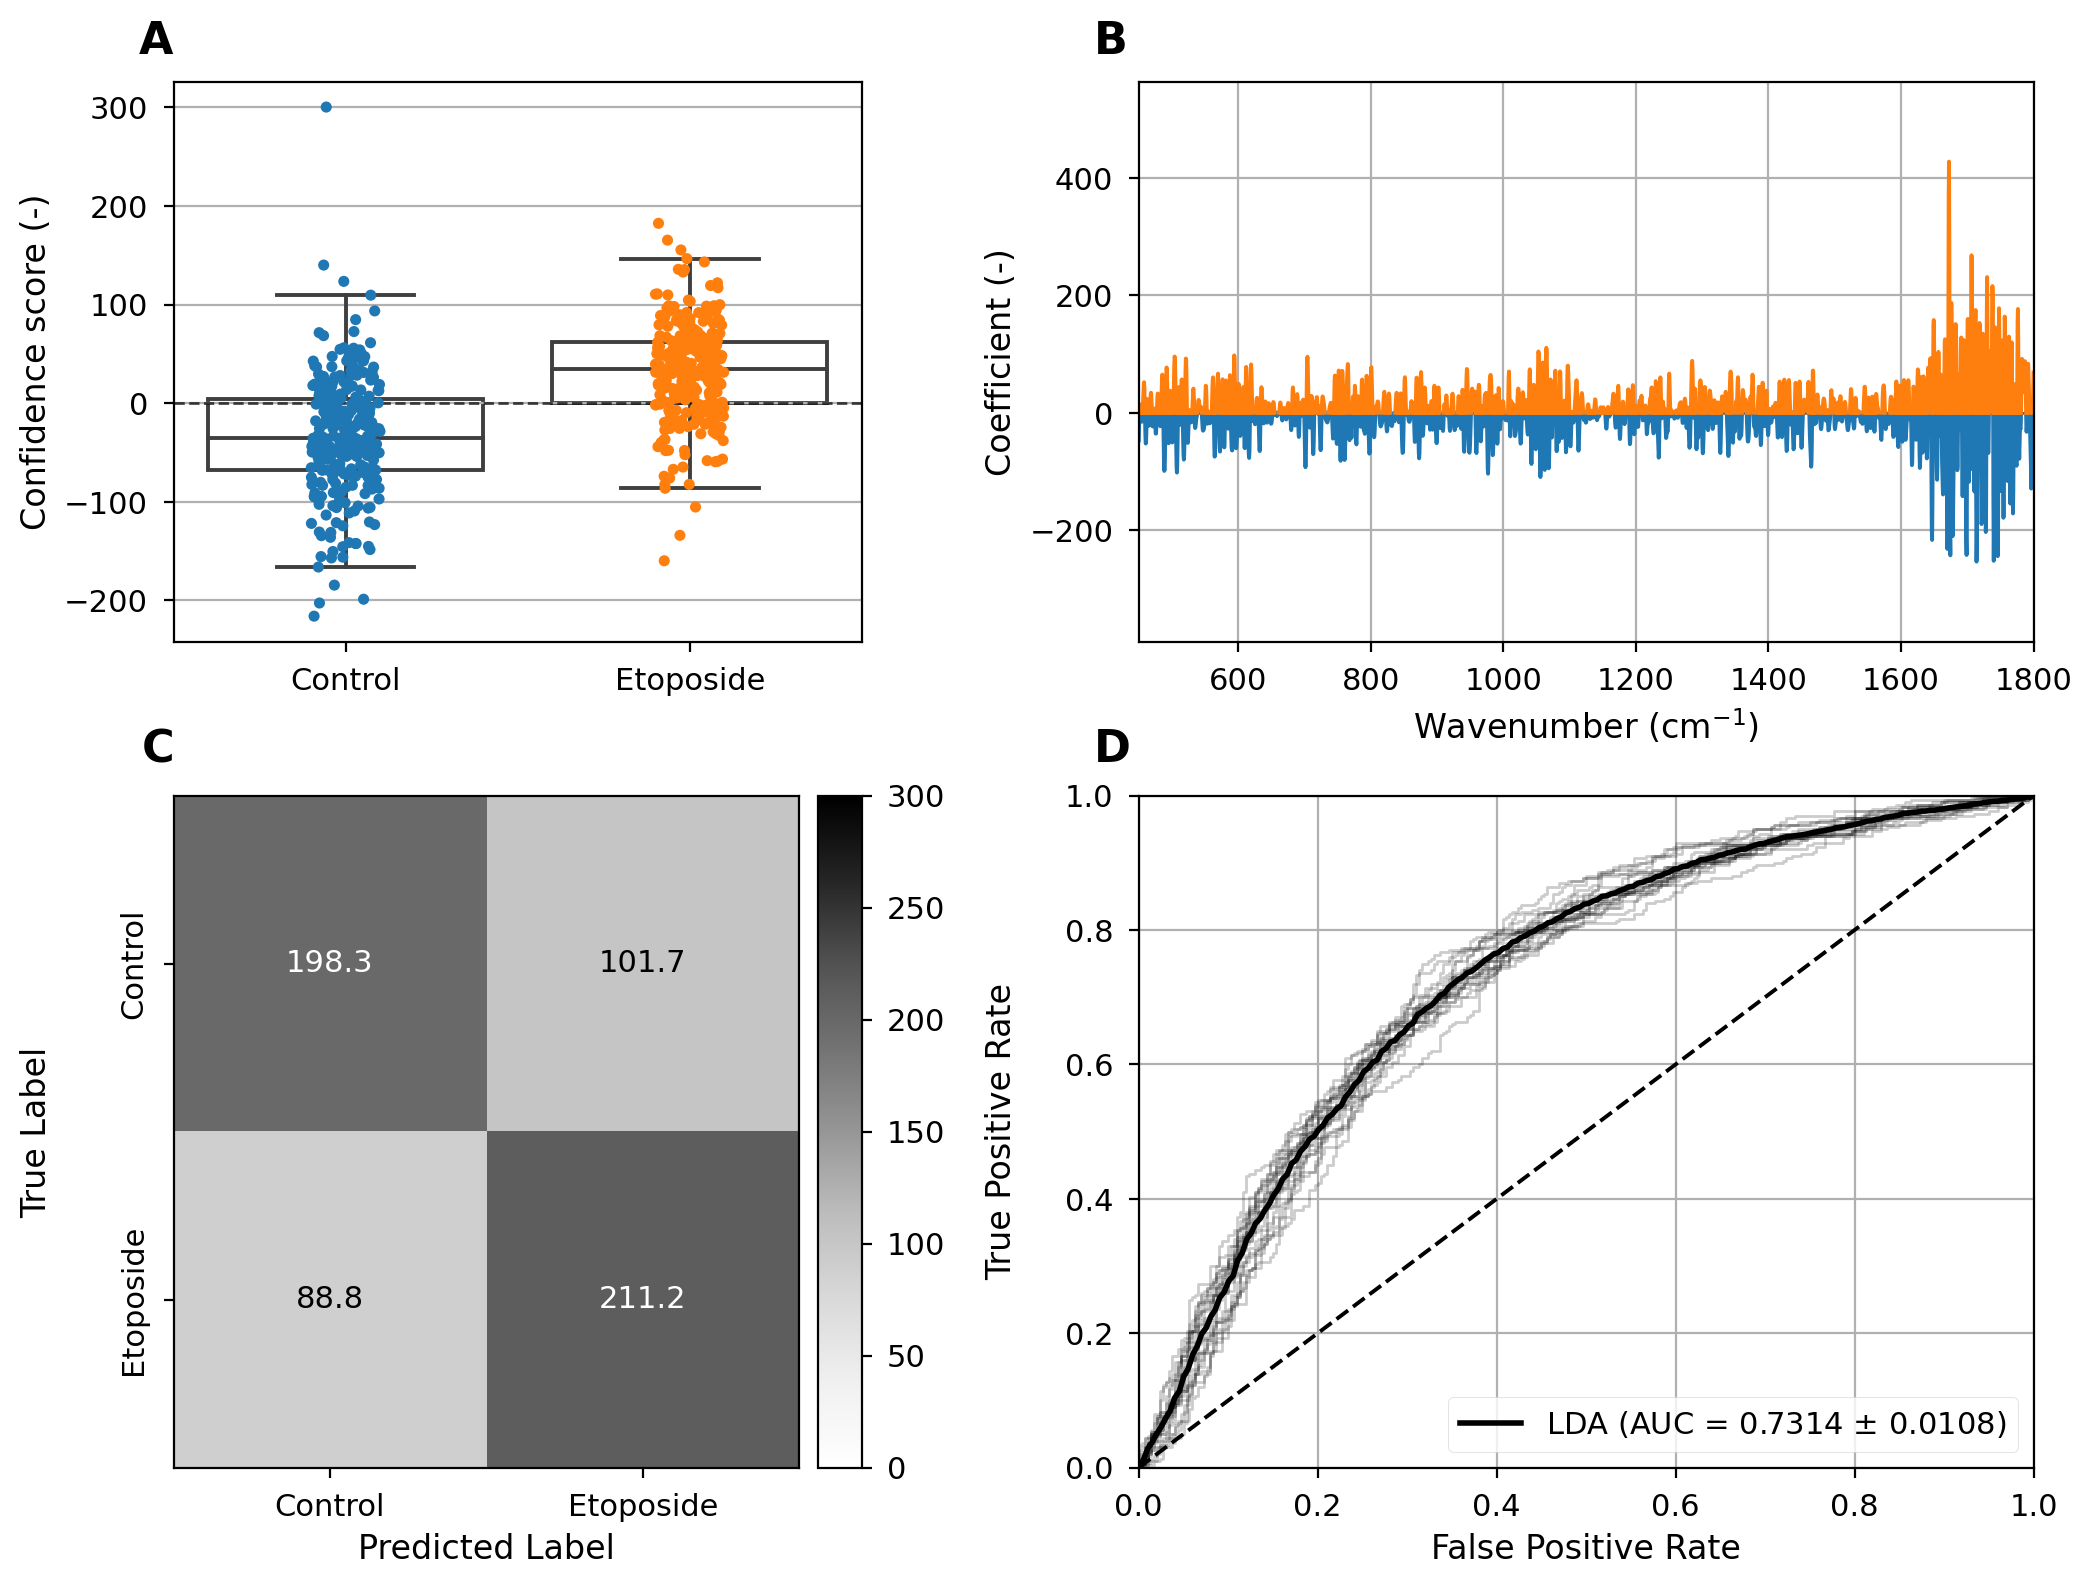

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,9),
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=4, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2)
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.2)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
_ = plot_roc_curve(conf_score_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right", fontsize=11)
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.25)
fig.align_labels()

fig.savefig(img_path / "lda_combined.png", format="png", bbox_inches="tight")

## PCA-LDA
### Overview

In [15]:
current_path = results_path / "lda_dim_reduction/pca_lda/"
name = "PCA-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_roc_auc  test_roc_auc  train_accuracy  test_accuracy   train_f1  \
count      20.000000     20.000000       20.000000      20.000000  20.000000   
mean        0.958504      0.943750        0.883833       0.864000   0.885411   
std         0.001519      0.004314        0.004242       0.006933   0.004131   
min         0.955531      0.936222        0.872083       0.851667   0.874380   
25%         0.957878      0.941694        0.882812       0.859583   0.884591   
50%         0.958510      0.943528        0.883958       0.865000   0.885654   
75%         0.959141      0.946903        0.885000       0.866667   0.886395   
max         0.962694      0.951889        0.892083       0.876667   0.893857   

         test_f1   fit_time  predict_time       p_value  
count  20.000000  20.000000     20.000000  2.000000e+01  
mean    0.865631   3.068046      0.009092  4.599636e-34  
std     0.007007   0.078677      0.001299  8.667799e-34  
min     0.852257   2.952521      0.007480  1.082349e-37  
25%     0.861926   3.006006      0.008487  4.515219e-36  
50%     0.865303   3.057002      0.008625  3.388190e-35  
75%     0.869514   3.133500      0.009461  3.040278e-34  
max     0.878561   3.230056      0.012986  2.742276e-33

### Validation Curve

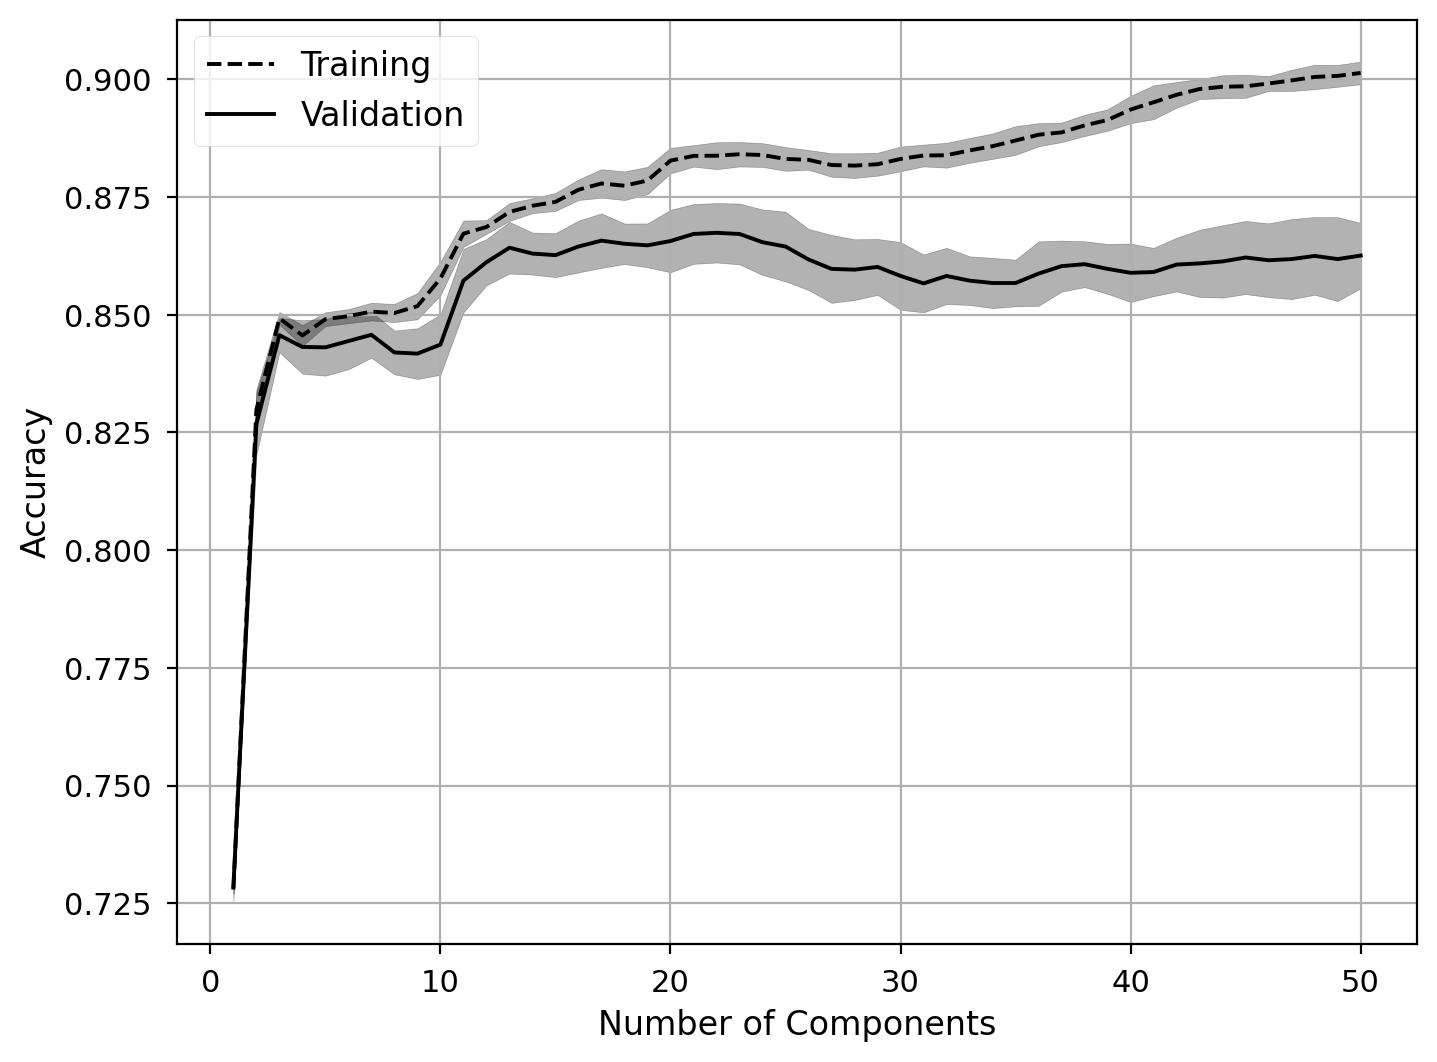

In [16]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

fig, ax = plt.subplots()
plot_validation_curve(cv_df, ax=ax)

ax.set_xlabel("Number of Components")
ax.set_ylabel("Accuracy")
ax.grid()
ax.legend(loc="upper left")

[Text(1, 0, 'Number of Components')]

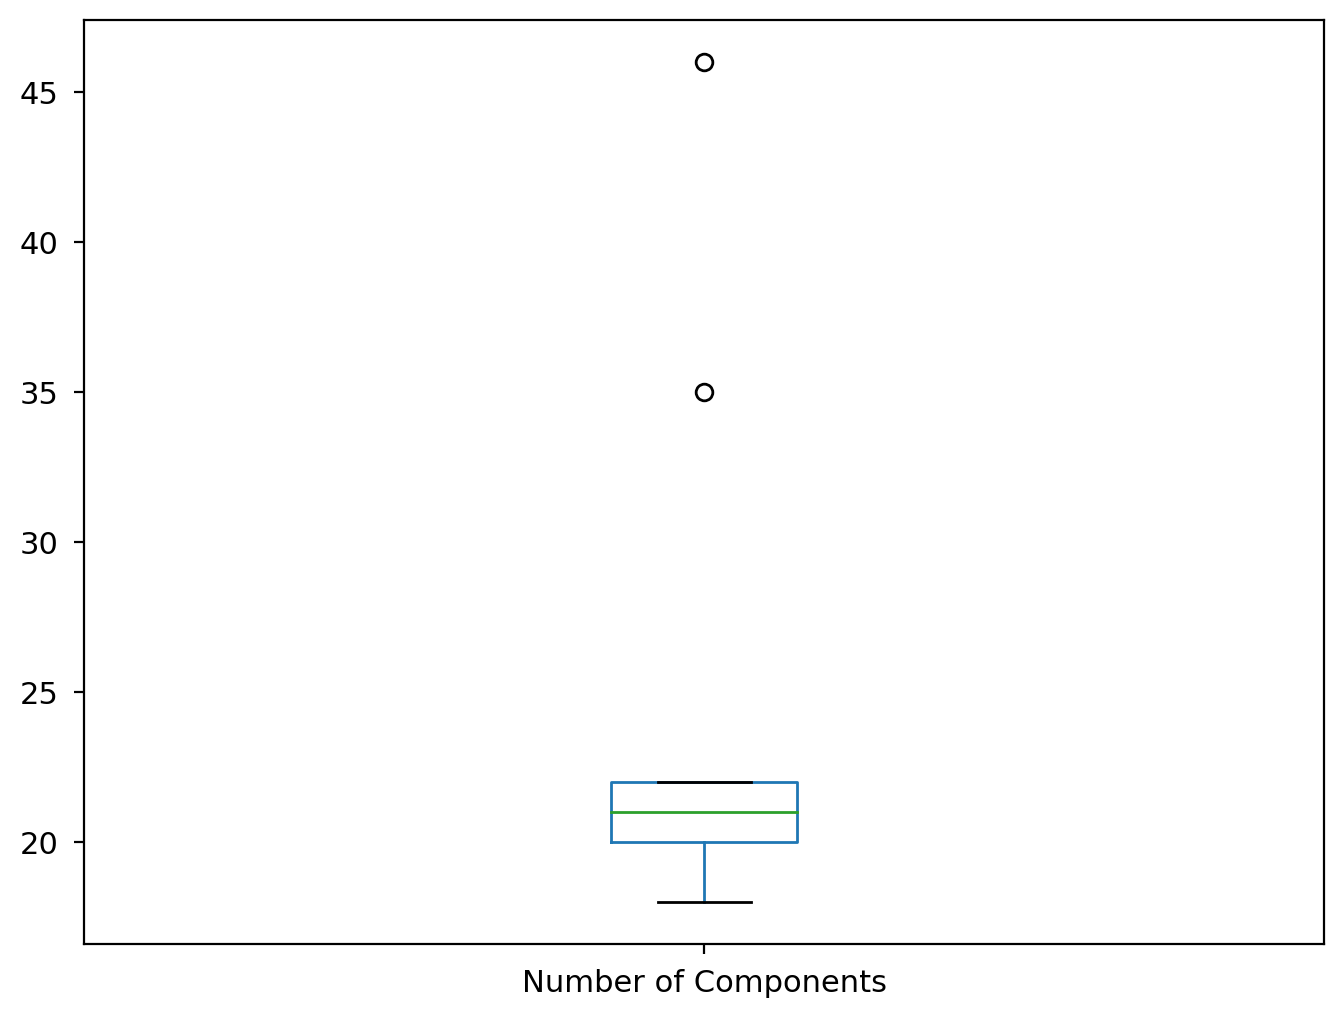

In [17]:
param_df = pd.read_csv(current_path / "param_results.csv")

fig, ax = plt.subplots()
param_df.boxplot(ax=ax, grid=False)
ax.set_xticklabels(["Number of Components"])

### Confidence scores by class

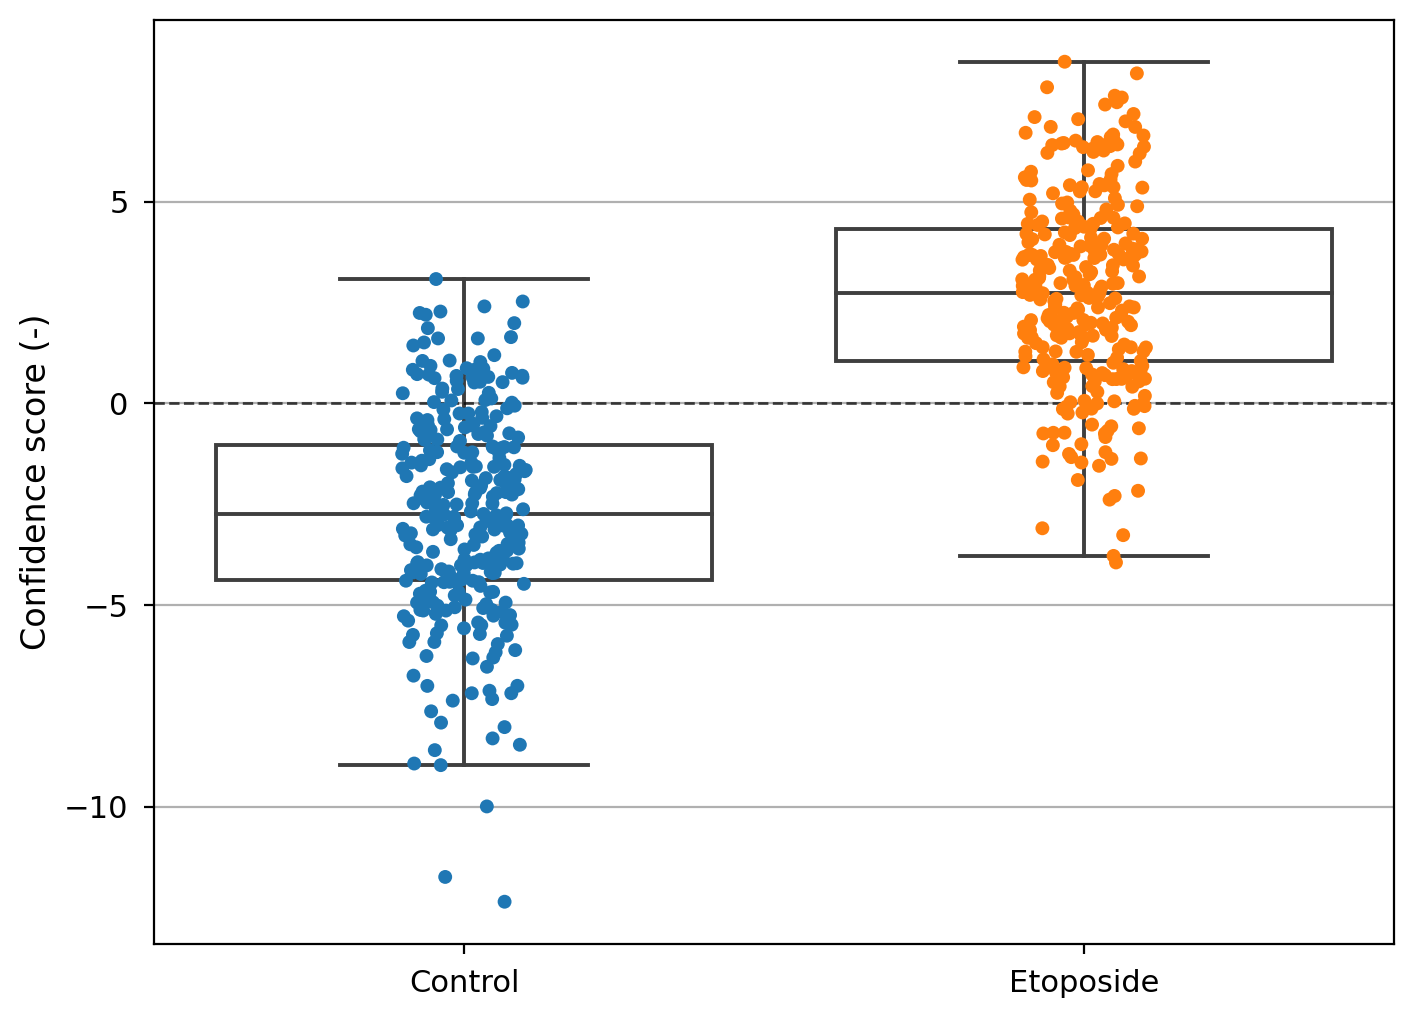

In [18]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)

fig, ax = plt.subplots()
plot_confidence_scores(conf_score_df, y_key[y], y_key, ax=ax)
ax.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax.set_ylabel("Confidence score (-)")
ax.grid(axis="y")

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

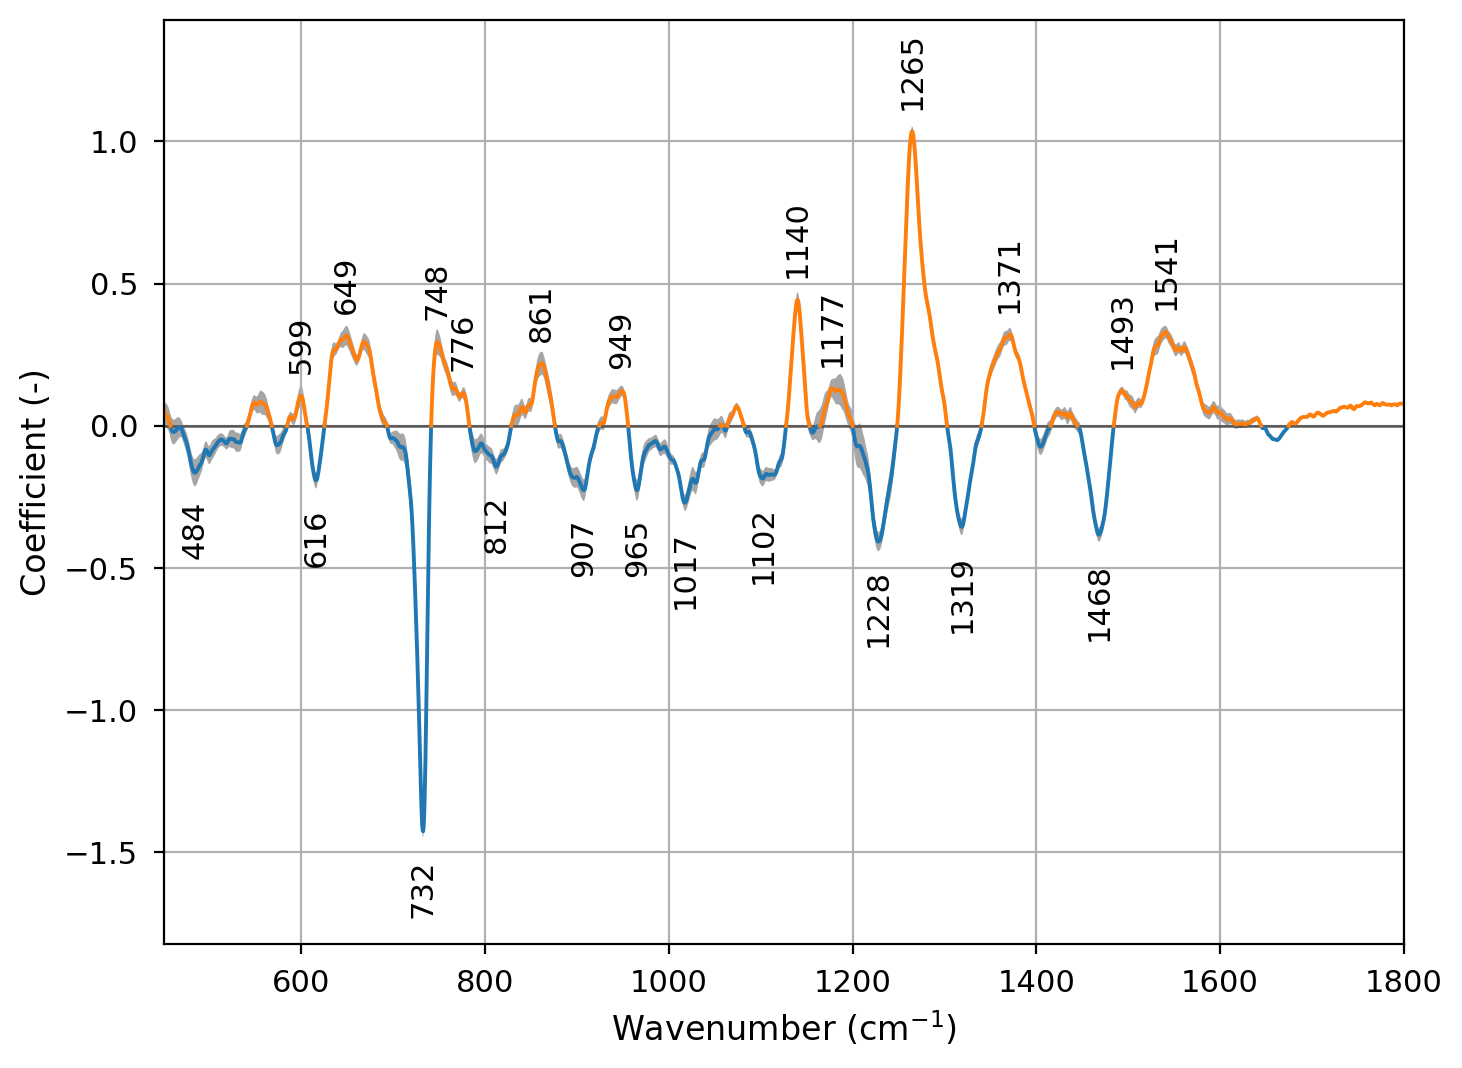

In [19]:
coef_df = pd.read_csv(current_path / "coefficients.csv")

fig, ax = plt.subplots()
plot_coefs(coef_df, ax=ax, show_range=True, annotate=True, annot_kw={"min_height": 0.1, 
                                                                     "min_dist": 50,
                                                                     "offset": 10})

ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("Coefficient (-)")
ax.margins(x=0, y=0.15)
ax.grid()

### Confusion Matrix

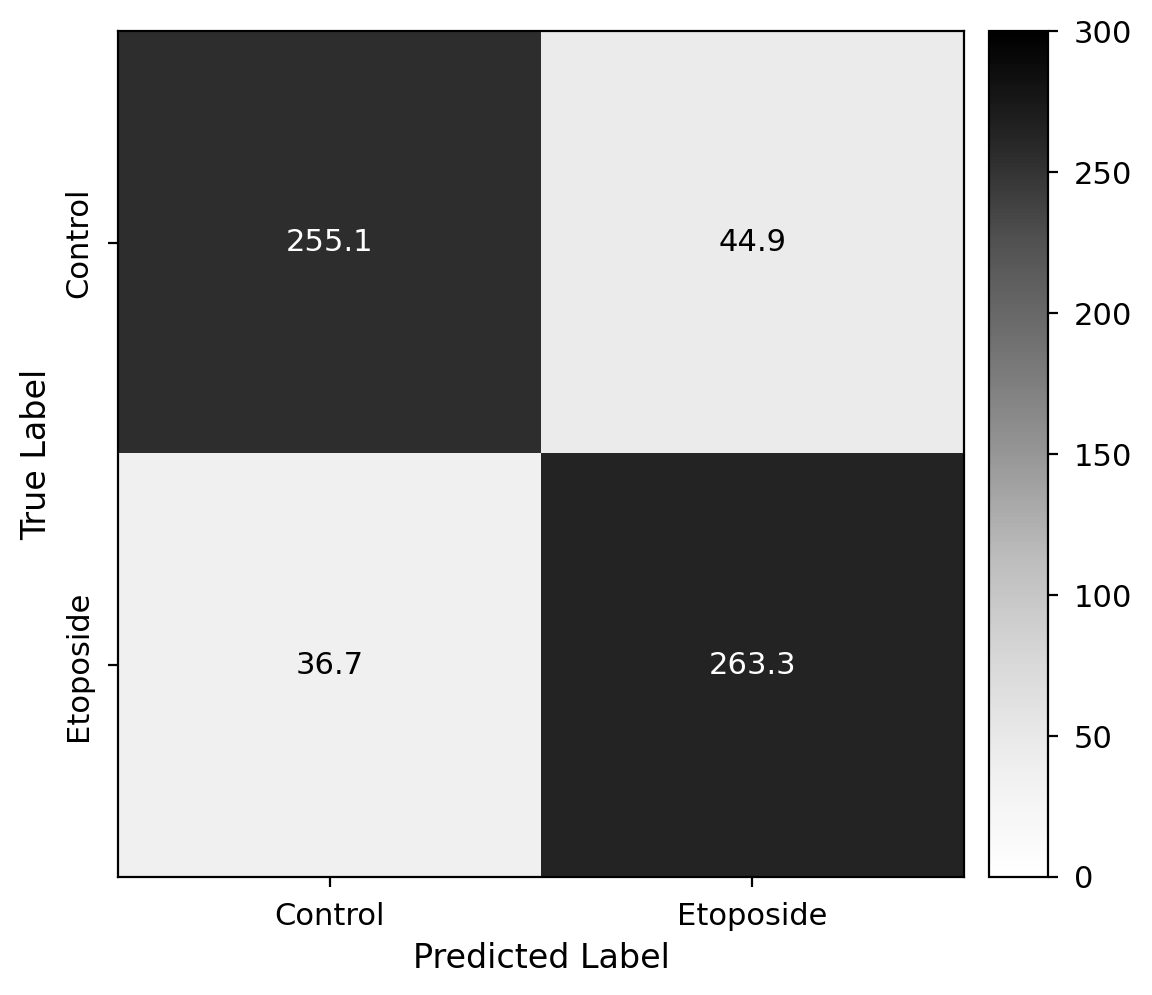

In [20]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

fig, ax = plt.subplots(figsize=(6,6))
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax, cmap="Greys", colorbar=True)

### ROC Curve

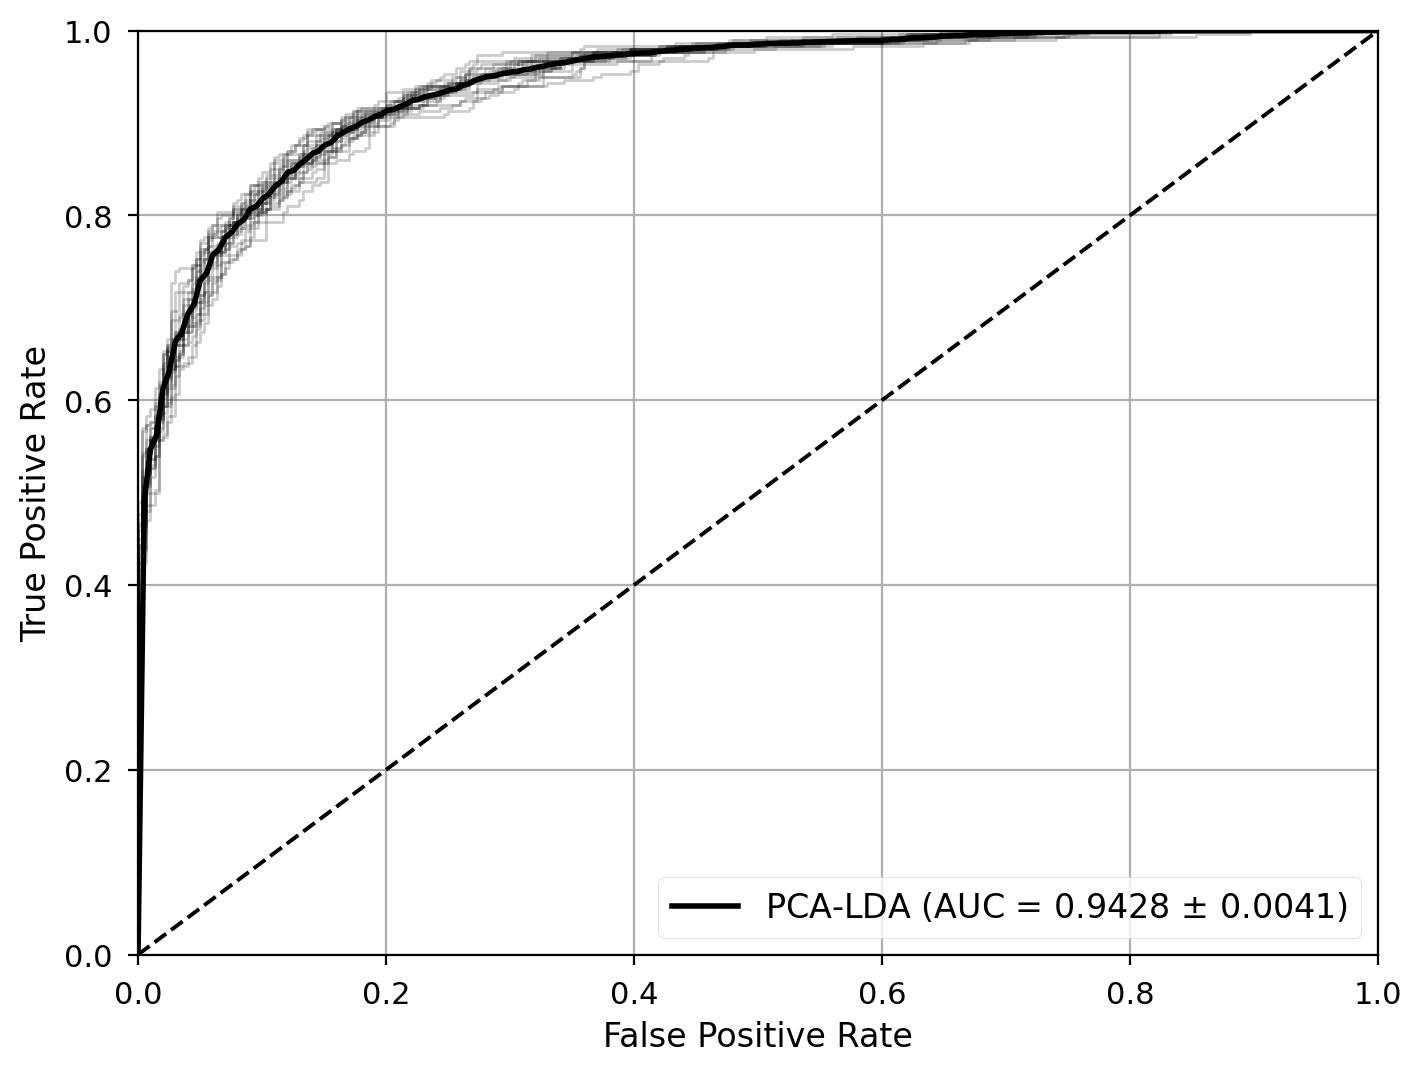

In [21]:
fig, ax = plt.subplots()
roc, auc = plot_roc_curve(conf_score_df, y, name, ax=ax)

ax.set_xlabel(f"False Positive Rate")
ax.set_ylabel(f"True Positive Rate")
ax.legend(loc="lower right")
ax.grid()

rocs[name] = roc
aucs[name] = auc

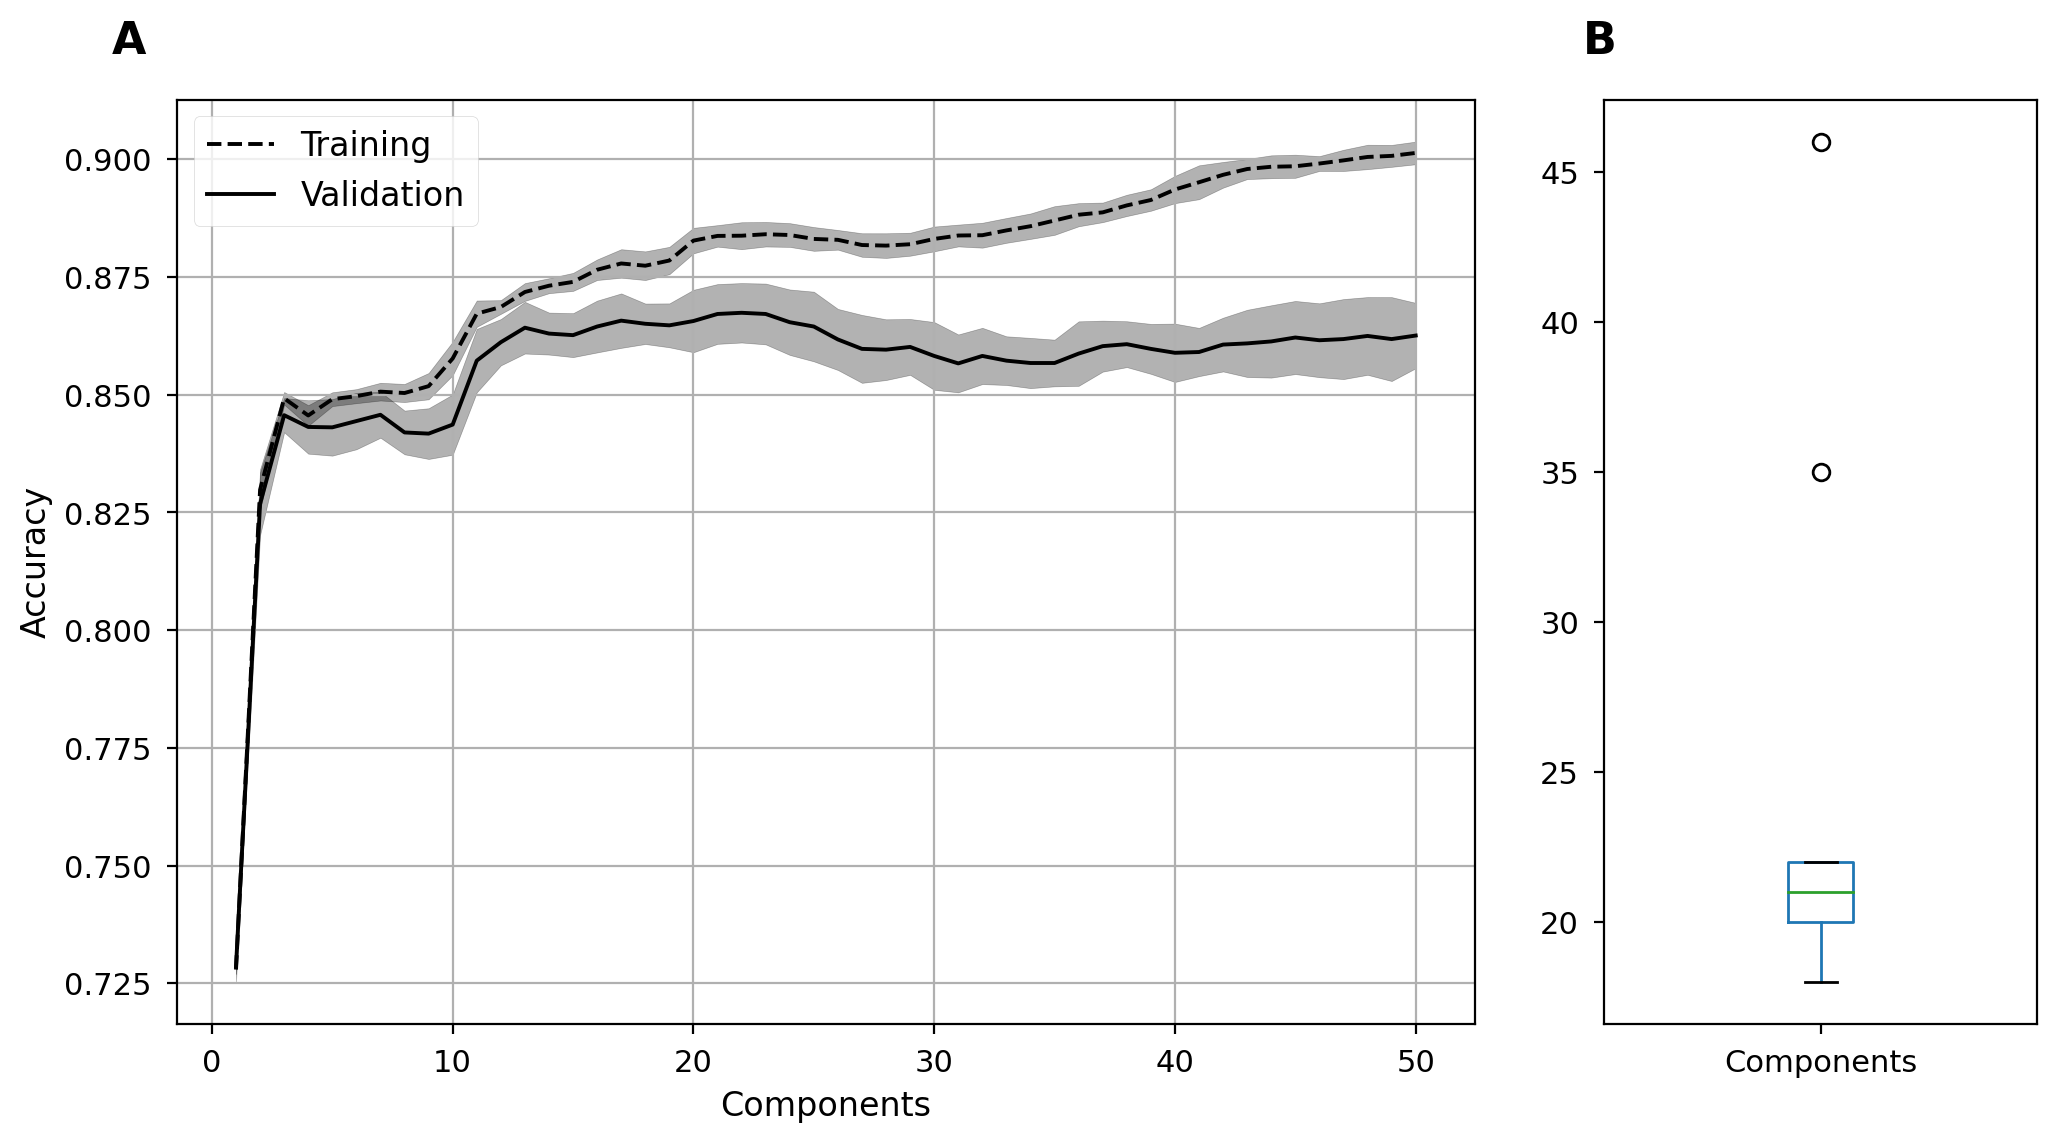

In [36]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xlabel("Components")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend(loc="upper left")

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False)

ax2.set_xticklabels(["Components"])

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.15)
fig.align_labels()

fig.savefig(img_path / "pcalda_validation.png", format="png", bbox_inches="tight")

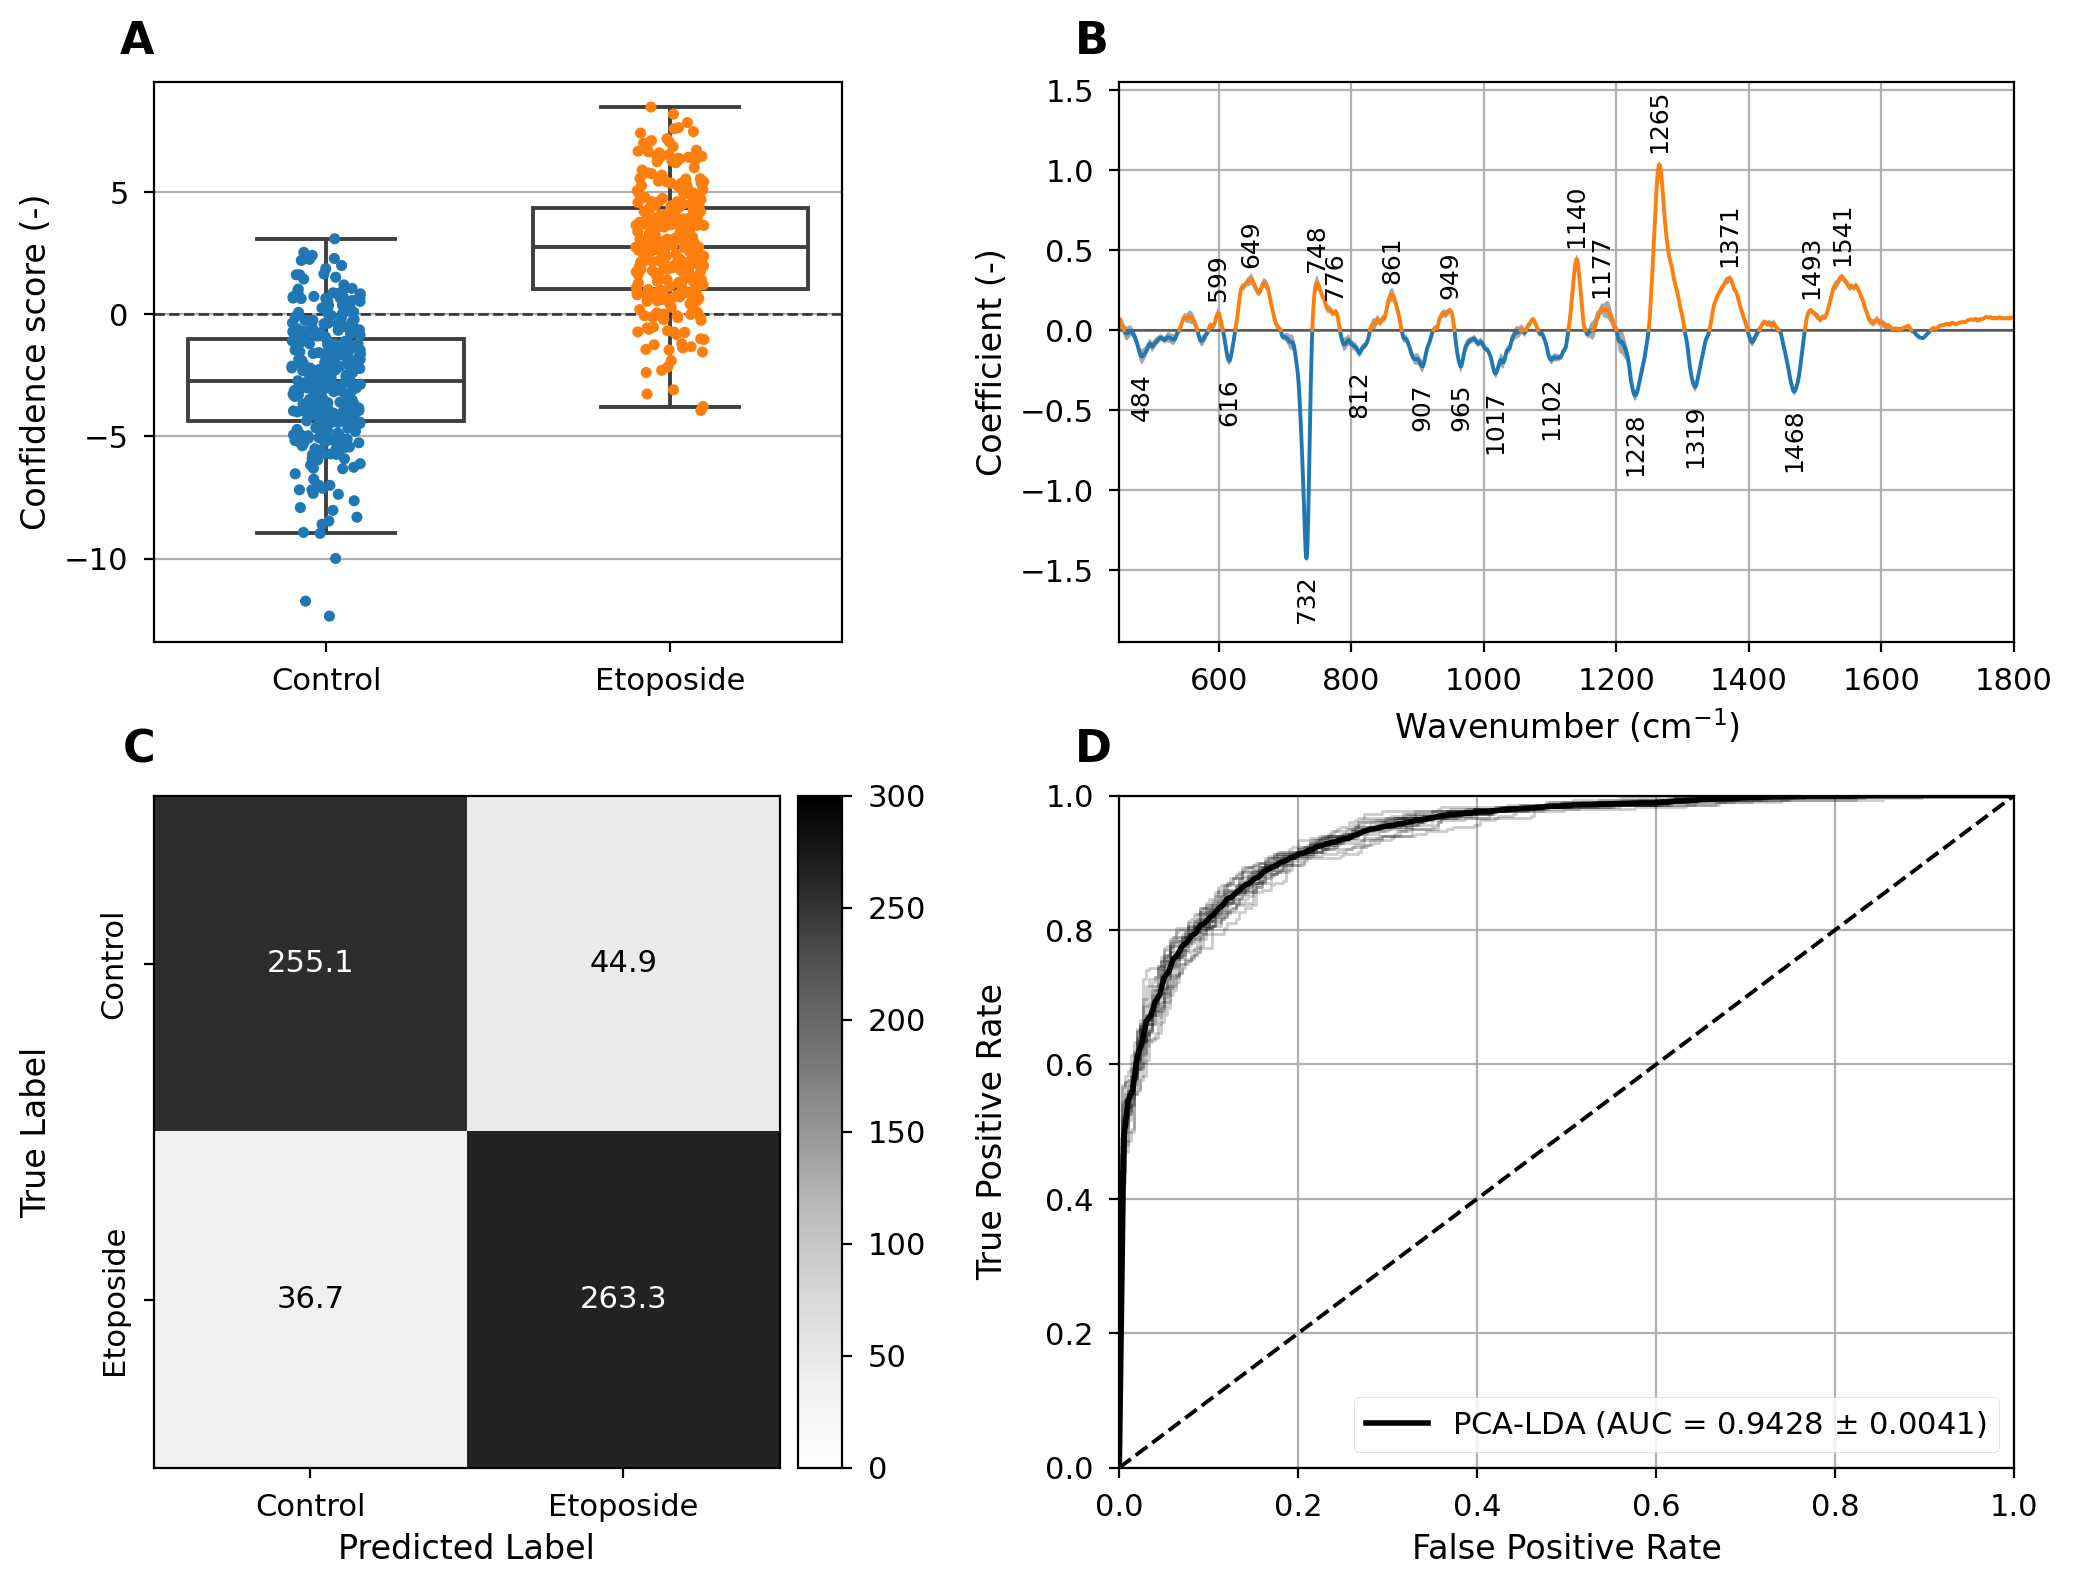

In [40]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,9),
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=4, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True, annotate=True, annot_kw={"min_height": 0.1, 
                                                                      "min_dist": 50,
                                                                      "offset": 6,
                                                                      "fontsize": 9})
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.2)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
_ = plot_roc_curve(conf_score_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right", fontsize=11)
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.25)
fig.align_labels()

fig.savefig(img_path / "pcalda_combined.png", format="png", bbox_inches="tight")

## NMF-LDA
### Overview

In [ ]:
current_path = results_path / "lda_dim_reduction/nmf_lda/"
name = "NMF-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_roc_auc  test_roc_auc  train_accuracy  test_accuracy   train_f1  \
count      20.000000     20.000000       20.000000      20.000000  20.000000   
mean        0.962771      0.922703        0.890514       0.839022   0.898697   
std         0.007138      0.012134        0.012395       0.018704   0.010887   
min         0.948575      0.892251        0.873099       0.800810   0.882396   
25%         0.956770      0.915658        0.880244       0.827497   0.889381   
50%         0.964807      0.923655        0.890678       0.837787   0.898518   
75%         0.967217      0.928618        0.898568       0.849730   0.906277   
max         0.976293      0.942953        0.920184       0.869096   0.925045   

         test_f1   fit_time  predict_time       p_value  
count  20.000000  20.000000     20.000000  2.000000e+01  
mean    0.853936   2.896243      0.008280  3.325566e-10  
std     0.016759   0.173788      0.008202  6.989576e-10  
min     0.823296   2.703870      0.003653  7.071312e-13  
25%     0.842050   2.747844      0.004722  7.589408e-12  
50%     0.852536   2.842442      0.005944  9.464287e-11  
75%     0.863945   2.997787      0.007515  3.536902e-10  
max     0.882381   3.233315      0.039970  3.104971e-09

### Validation Curve

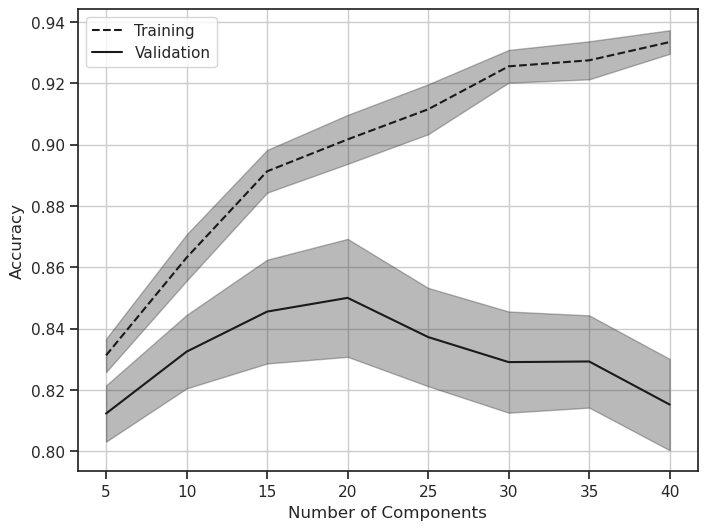

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="Number of Components", y_label="Accuracy")

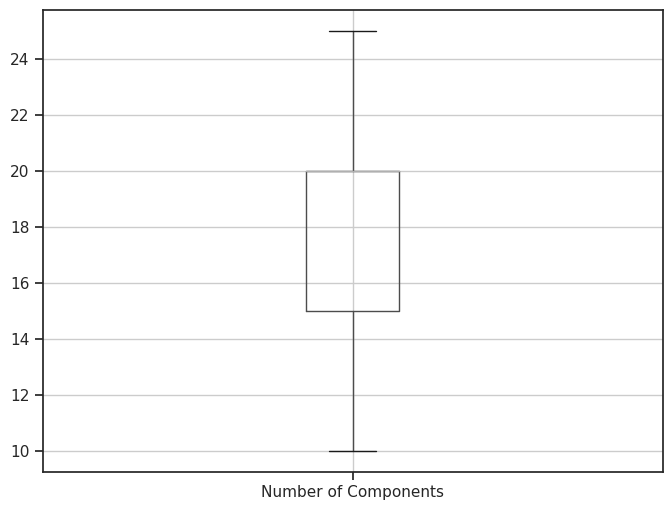

In [ ]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="Number of Components")

### Confidence scores by class

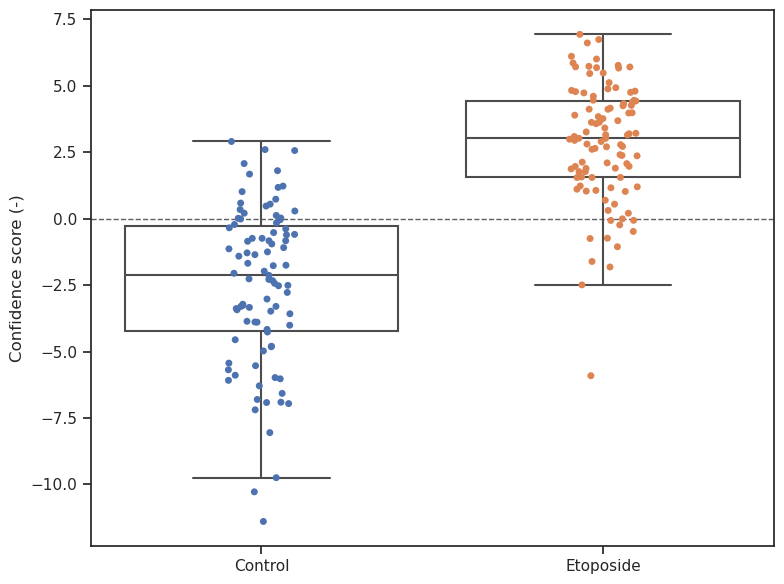

In [ ]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

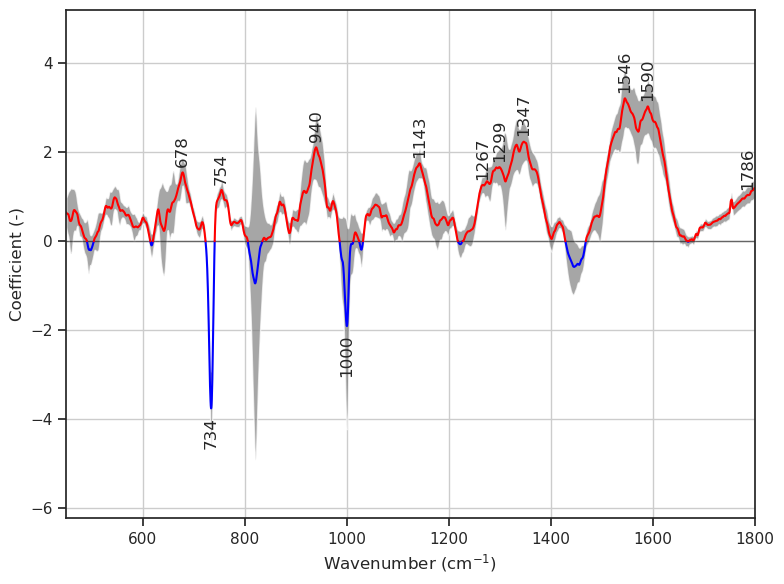

In [ ]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=1, min_dist=50)

### Confusion Matrix

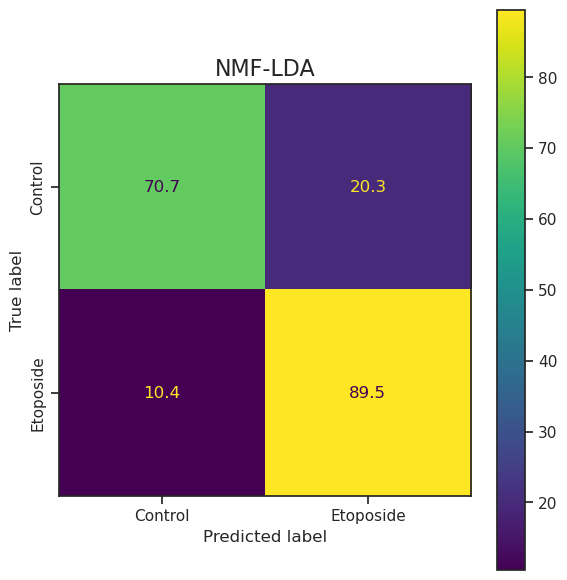

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

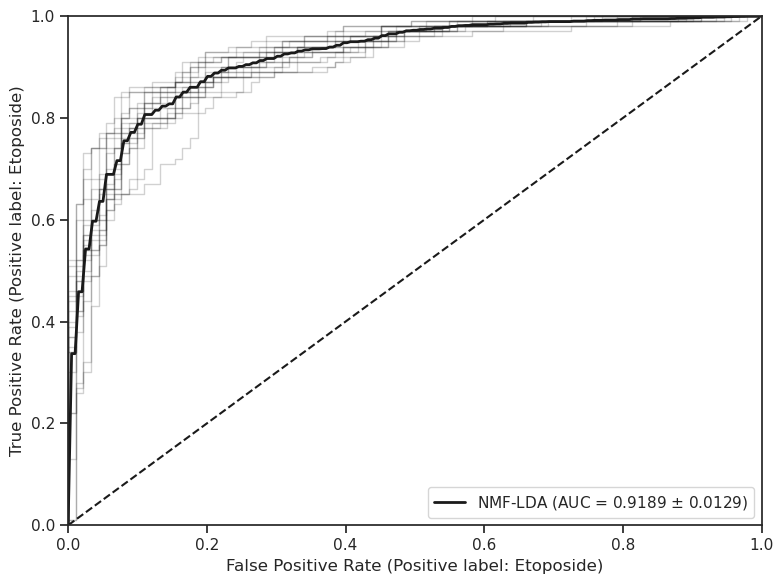

In [ ]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Feature Agglomeration (FA) - LDA
### Overview

In [ ]:
current_path = results_path / "lda_dim_reduction/fa_lda/"
name = "FA-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_roc_auc  test_roc_auc  train_accuracy  test_accuracy   train_f1  \
count      20.000000     20.000000       20.000000      20.000000  20.000000   
mean        0.937830      0.893341        0.849287       0.801694   0.864484   
std         0.008792      0.013516        0.012963       0.021925   0.010946   
min         0.923595      0.864211        0.828517       0.764777   0.847084   
25%         0.930989      0.882851        0.842995       0.783131   0.859478   
50%         0.936724      0.895015        0.846255       0.806343   0.861721   
75%         0.944842      0.904803        0.857918       0.821896   0.871501   
max         0.955350      0.911316        0.882233       0.832389   0.892216   

         test_f1   fit_time  predict_time       p_value  
count  20.000000  20.000000     20.000000  2.000000e+01  
mean    0.822785   2.831219      0.003522  3.157290e-08  
std     0.019543   0.545987      0.004426  6.099546e-08  
min     0.786186   2.394480      0.001574  3.850647e-11  
25%     0.807547   2.505250      0.002180  4.121812e-10  
50%     0.826534   2.638664      0.002396  1.940068e-09  
75%     0.839732   2.888747      0.002890  3.331398e-08  
max     0.850485   4.591676      0.022062  2.445160e-07

### Validation Curve

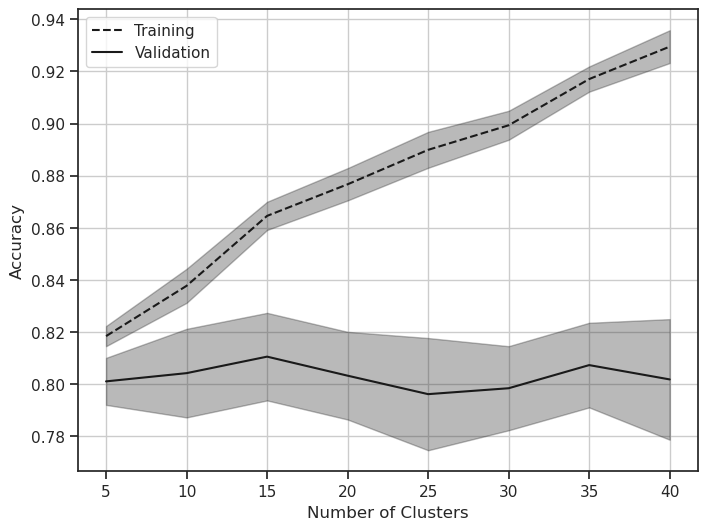

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="Number of Clusters", y_label="Accuracy")

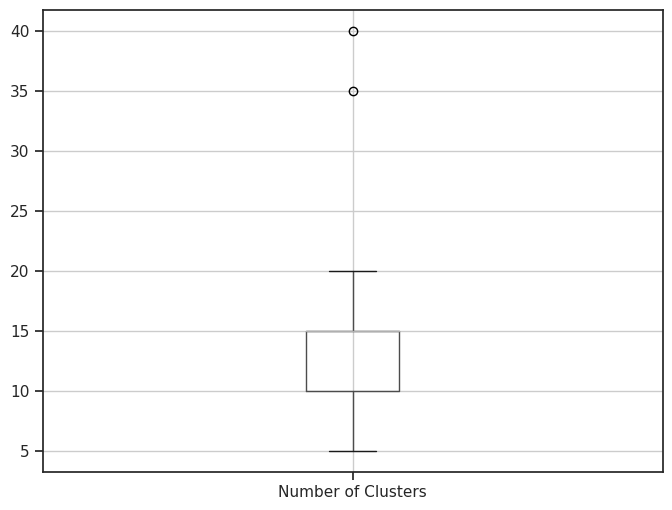

In [ ]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="Number of Clusters")

### Confidence scores by class

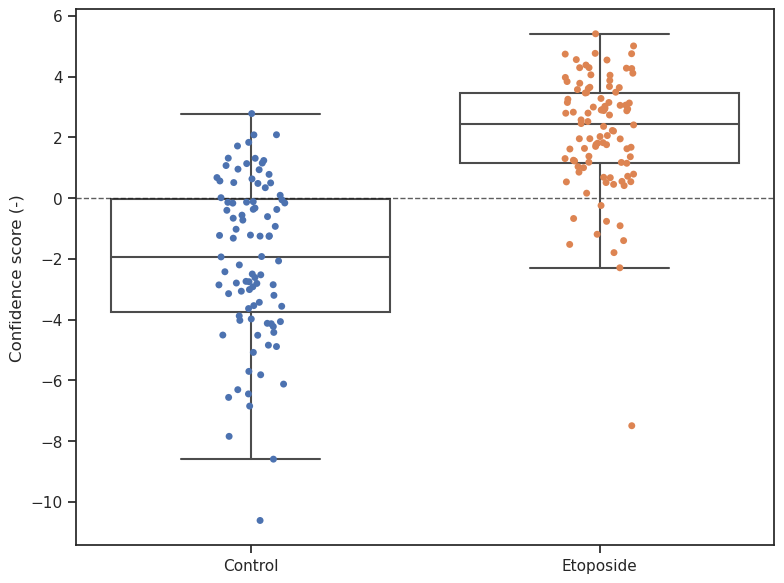

In [ ]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

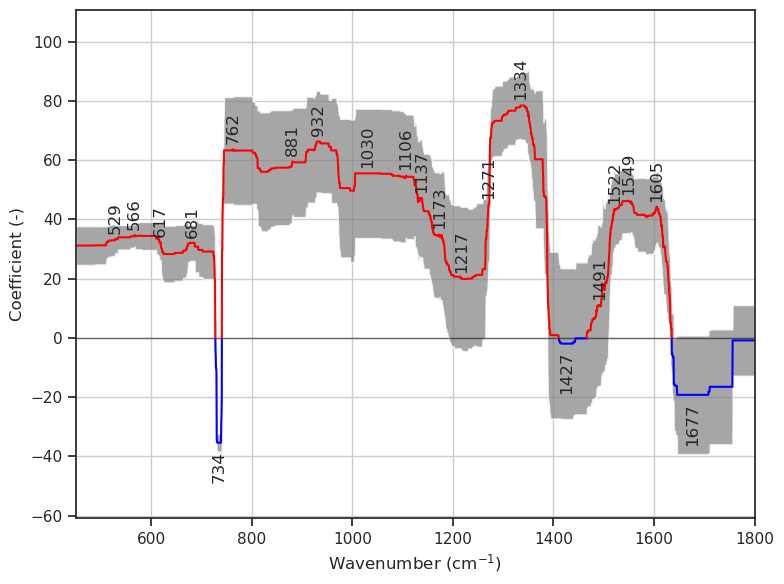

In [ ]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=1, min_dist=50)

### Confusion Matrix

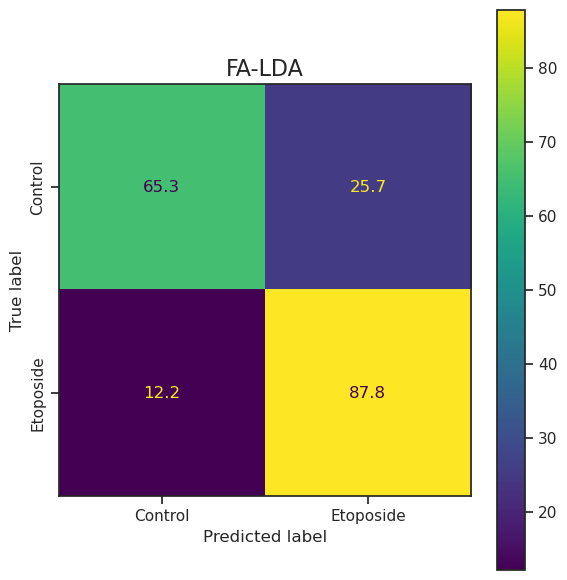

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

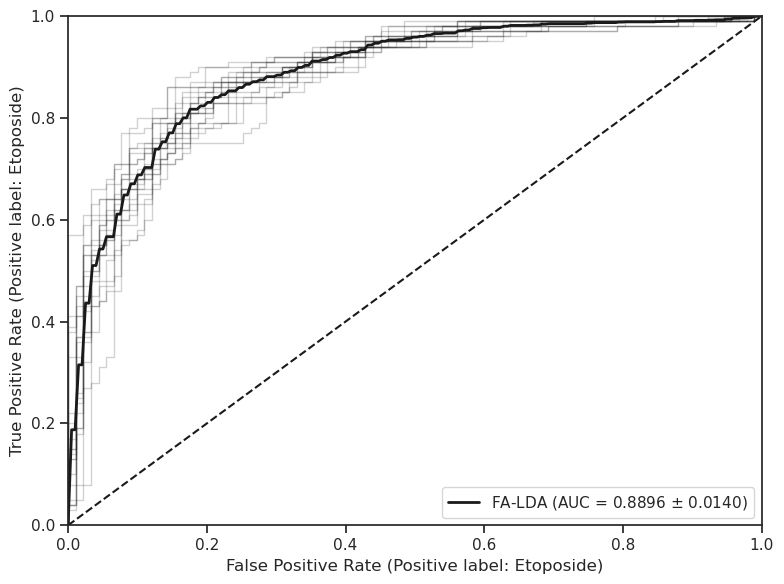

In [ ]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Peak-LDA
### Overview

In [ ]:
current_path = results_path / "lda_dim_reduction/peak_lda/"
name = "Peak-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_roc_auc  test_roc_auc  train_accuracy  test_accuracy   train_f1  \
count      20.000000     20.000000       20.000000      20.000000  20.000000   
mean        0.971783      0.917323        0.908515       0.835148   0.917351   
std         0.005276      0.013597        0.010877       0.020929   0.009371   
min         0.958802      0.884152        0.892733       0.806478   0.902718   
25%         0.968847      0.911645        0.899841       0.817274   0.909997   
50%         0.972769      0.918962        0.907749       0.832389   0.916858   
75%         0.976236      0.925994        0.914297       0.848448   0.922269   
max         0.978189      0.937632        0.929326       0.874359   0.935788   

         test_f1   fit_time  predict_time       p_value  
count  20.000000  20.000000     20.000000  2.000000e+01  
mean    0.853254   0.381864      0.002006  3.235637e-10  
std     0.018605   0.030310      0.000315  5.424755e-10  
min     0.827526   0.336067      0.001643  3.020565e-13  
25%     0.836298   0.364826      0.001767  1.285614e-12  
50%     0.850995   0.375583      0.001890  3.850647e-11  
75%     0.868790   0.387227      0.002131  3.332652e-10  
max     0.883833   0.468051      0.002769  1.927163e-09

### Validation Curve

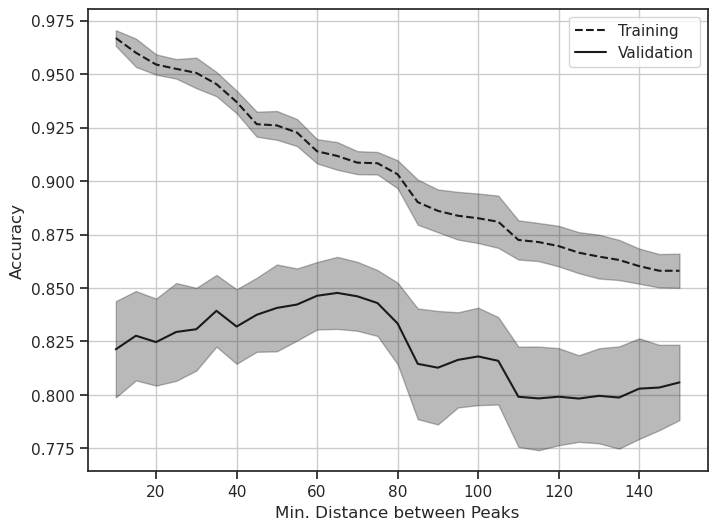

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="Min. Distance between Peaks", y_label="Accuracy")

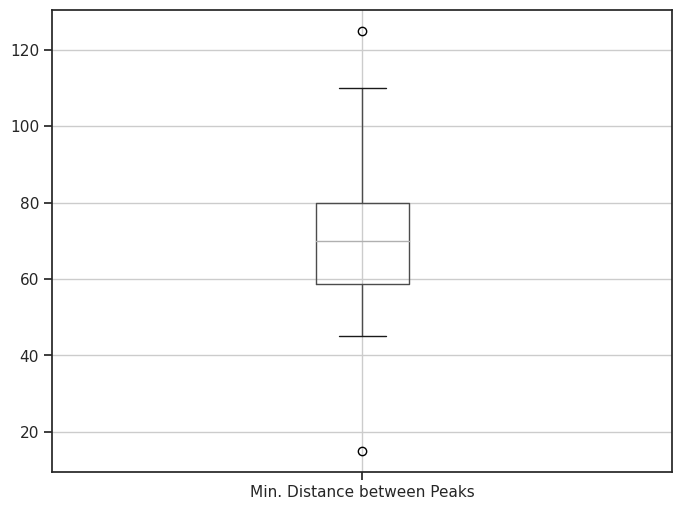

In [ ]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="Min. Distance between Peaks")

### Confidence scores by class

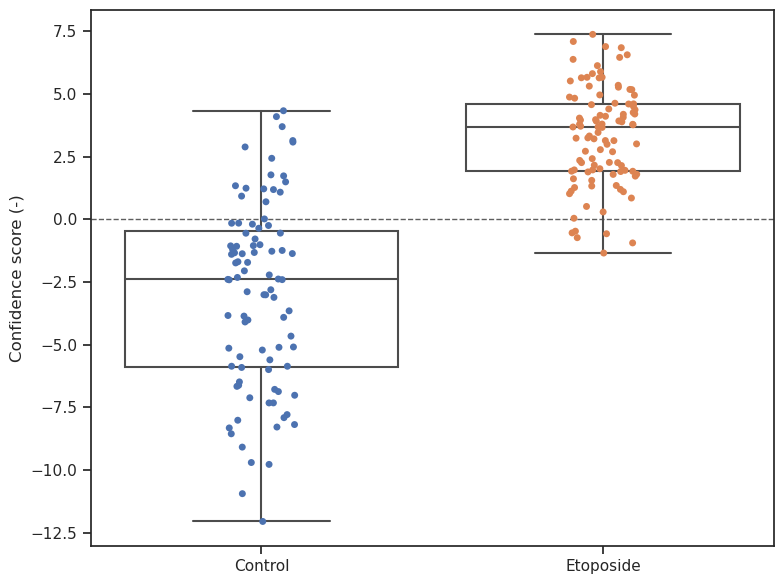

In [ ]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

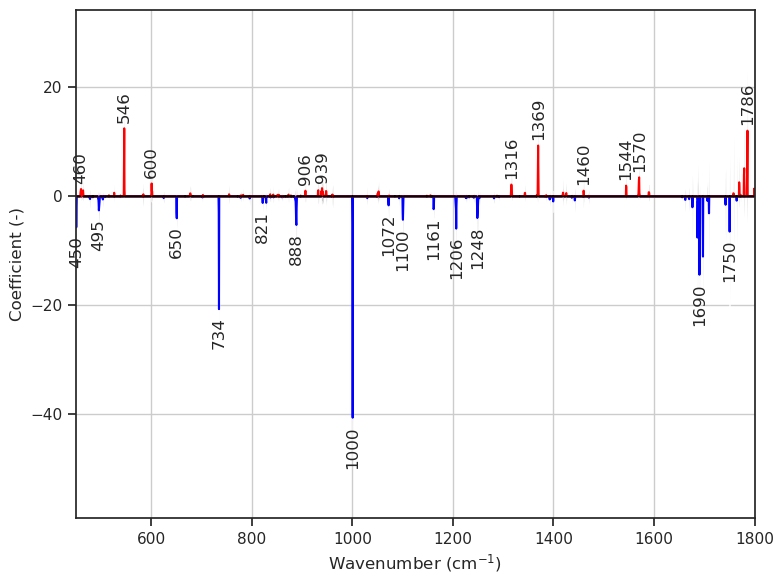

In [ ]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=1, min_dist=50)

### Confusion Matrix

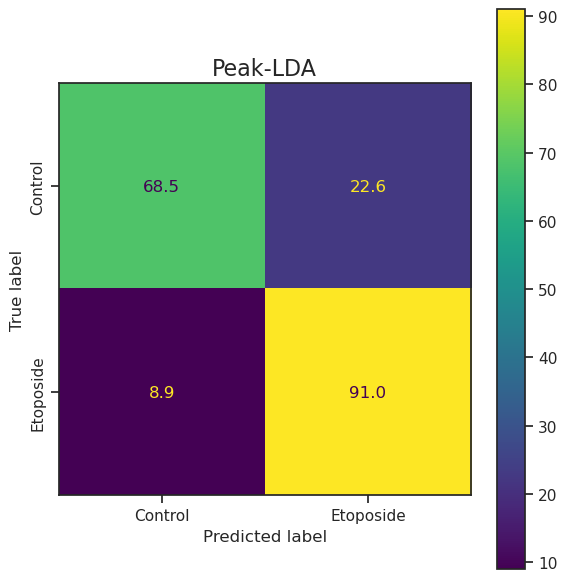

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

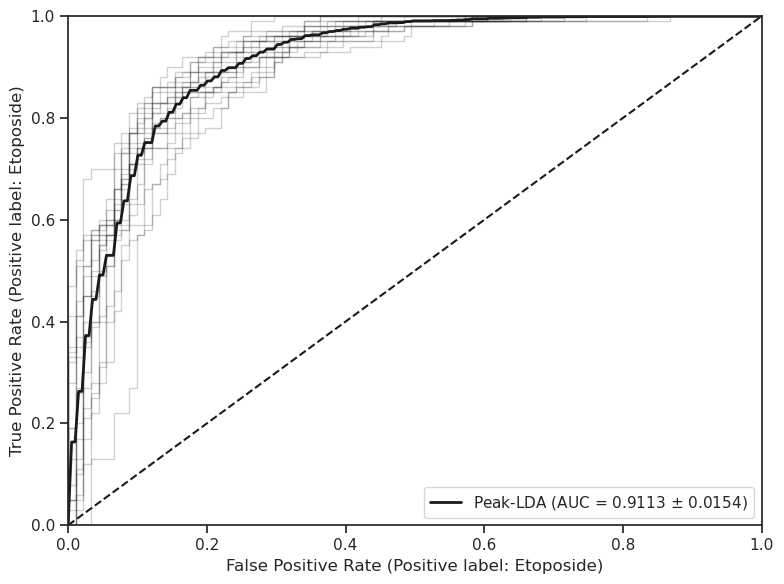

In [ ]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Comparison of LDA with different dimensionality Reductions

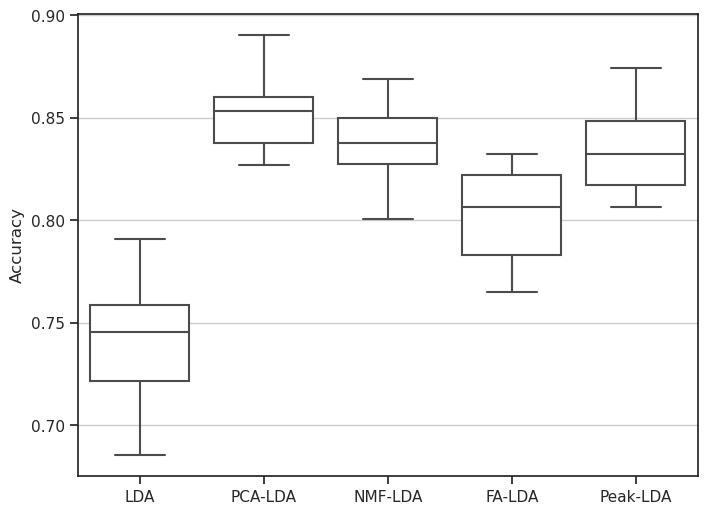

In [ ]:
boxplot_comparison(accs, ylabel="Accuracy")

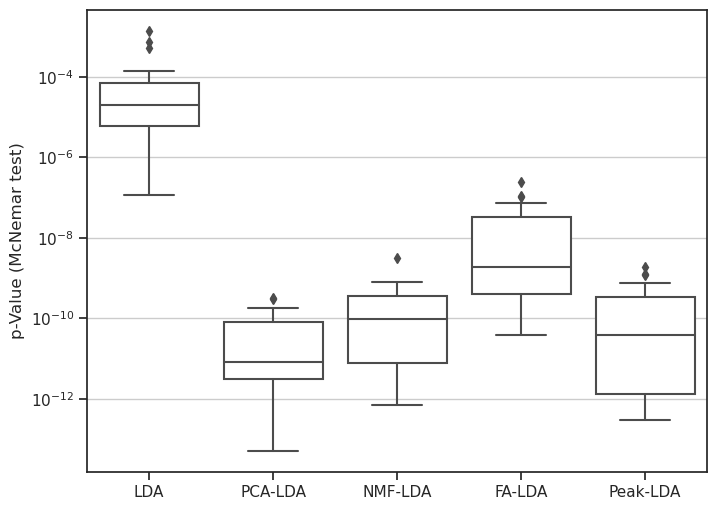

In [ ]:
boxplot_comparison(p_vals, ylabel="p-Value (McNemar test)", log_scale=True)

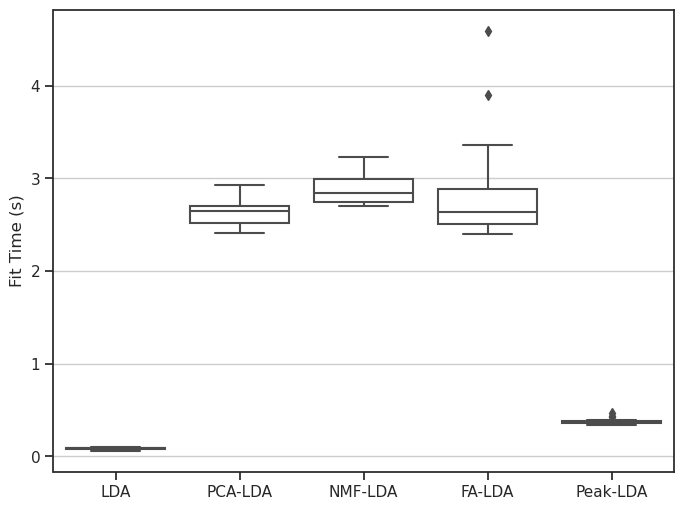

In [ ]:
boxplot_comparison(fit_times, ylabel="Fit Time (s)")

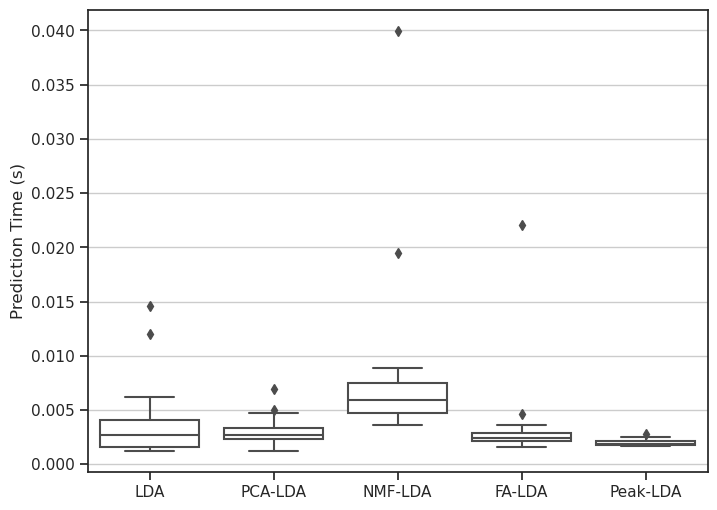

In [ ]:
boxplot_comparison(predict_times, ylabel="Prediction Time (s)")

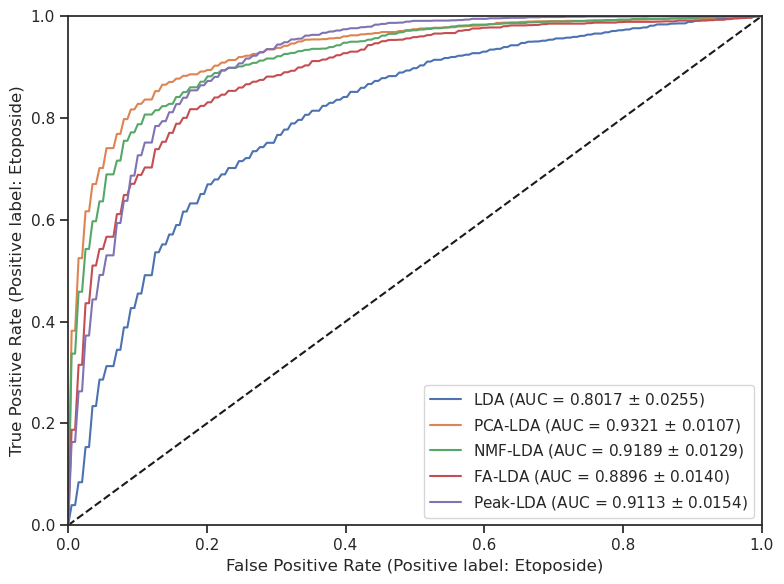

In [ ]:
plot_roc_comparison(rocs, aucs, labels=y_key)

# Regularized Models
## Logistic Regression (l1)
### Overview

In [ ]:
current_path = results_path / "regularized_models/logreg_l1/"
name = "Log. Reg. (l1)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_roc_auc  test_roc_auc  train_accuracy  test_accuracy   train_f1  \
count      20.000000     20.000000       20.000000      20.000000  20.000000   
mean        0.975624      0.946120        0.897773       0.860209   0.907969   
std         0.004016      0.007532        0.011698       0.010022   0.010227   
min         0.967991      0.932076        0.873039       0.838462   0.886619   
25%         0.973647      0.941944        0.889755       0.853340   0.900755   
50%         0.976255      0.945249        0.896612       0.863765   0.906833   
75%         0.977119      0.951645        0.908359       0.868995   0.917714   
max         0.983002      0.960058        0.912324       0.874224   0.921167   

         test_f1   fit_time  predict_time       p_value  
count  20.000000  20.000000     20.000000  2.000000e+01  
mean    0.874354   0.704004      0.014056  5.377210e-12  
std     0.009444   0.047481      0.010664  1.115571e-11  
min     0.854361   0.654269      0.004476  1.841850e-13  
25%     0.869387   0.667287      0.007909  3.313432e-13  
50%     0.876104   0.691017      0.009611  9.795839e-13  
75%     0.882831   0.722702      0.014527  3.152996e-12  
max     0.885443   0.804761      0.039975  4.522732e-11

### Validation Curve

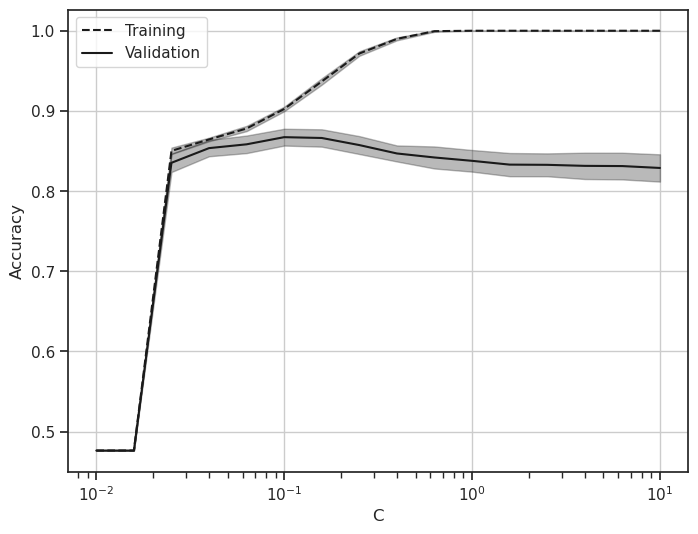

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="C", y_label="Accuracy", log_scale=True)

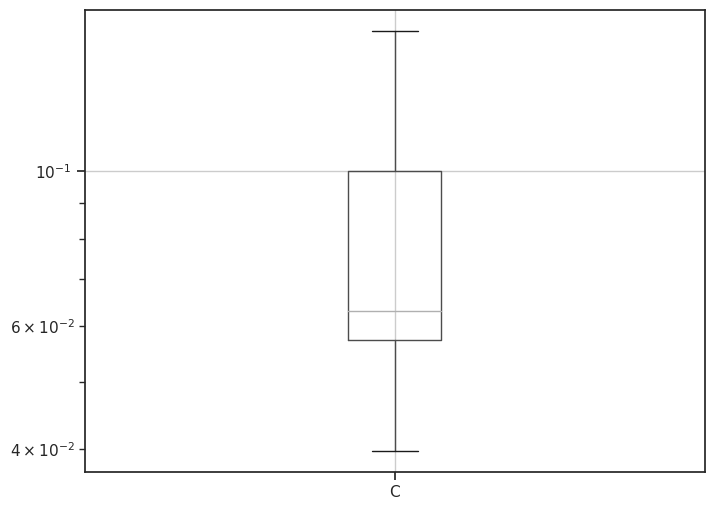

In [ ]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="C", log_scale=True)

### Confidence scores by class

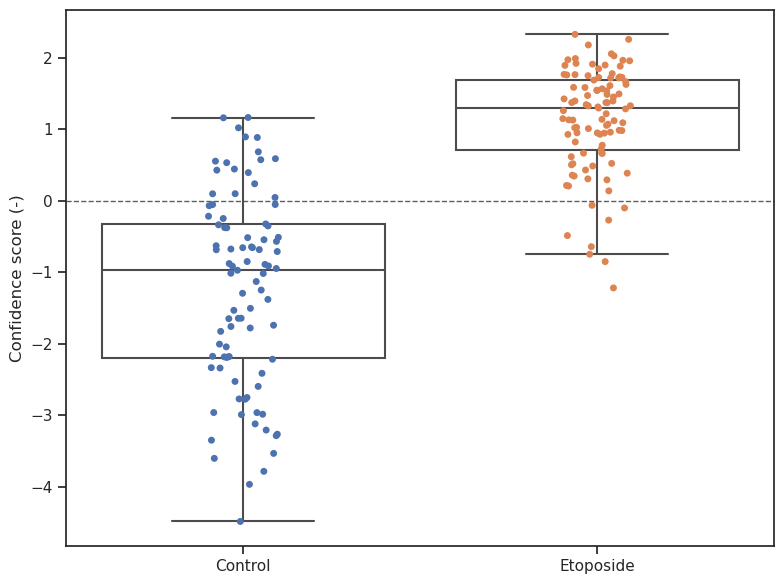

In [ ]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

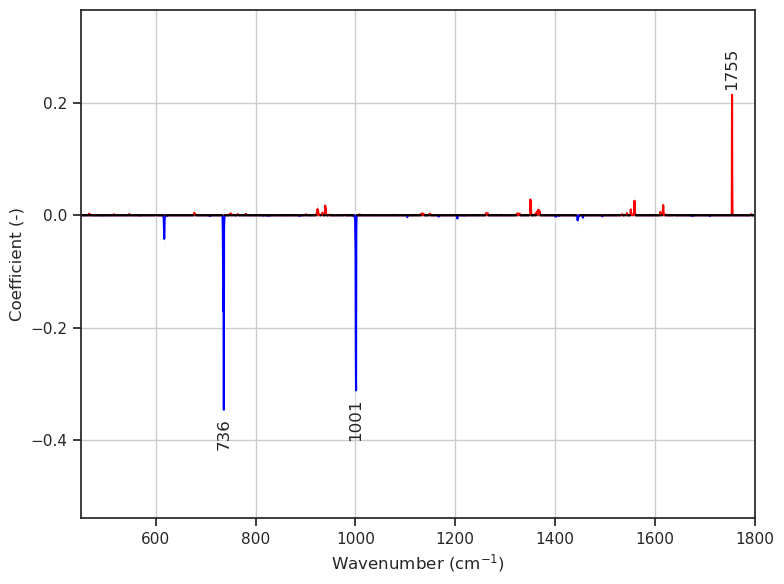

In [ ]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=0.1, min_dist=50)

### Confusion Matrix

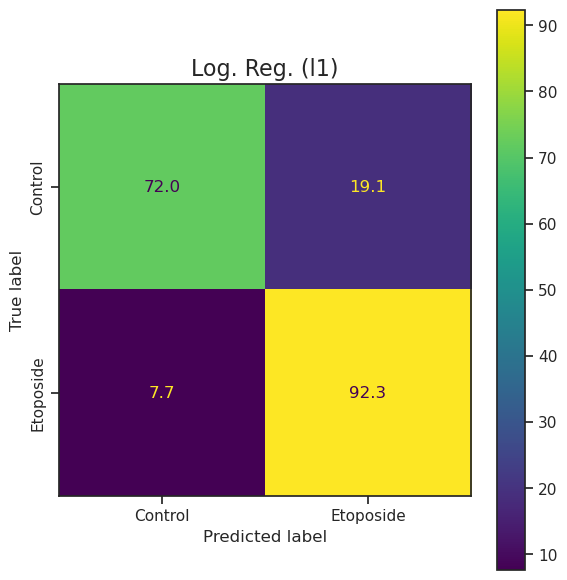

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

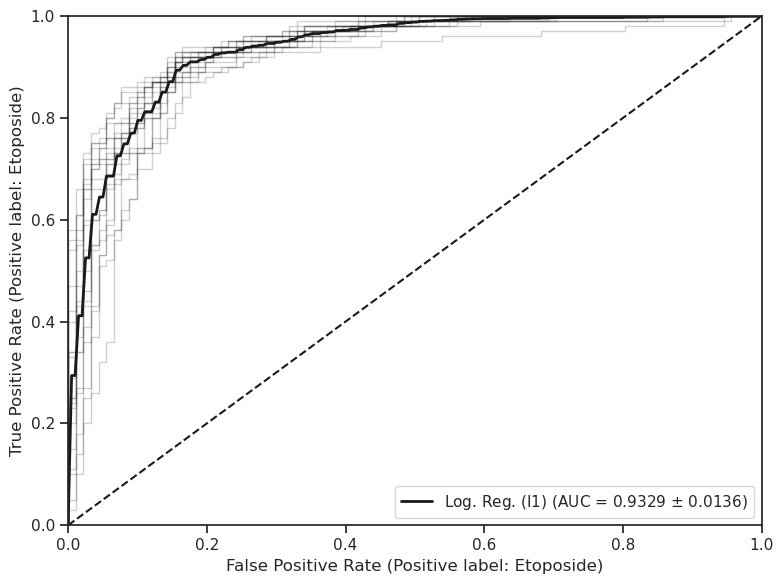

In [ ]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Logistic Regression (l2)
### Overview

In [ ]:
current_path = results_path / "regularized_models/logreg_l2/"
name = "Log. Reg. (l2)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_roc_auc  test_roc_auc  train_accuracy  test_accuracy   train_f1  \
count      20.000000     20.000000       20.000000      20.000000  20.000000   
mean        0.992992      0.911579        0.969634       0.822132   0.970817   
std         0.003020      0.009174        0.009674       0.016794   0.009294   
min         0.988184      0.893070        0.954180       0.786100   0.956000   
25%         0.990264      0.906564        0.964601       0.815688   0.965912   
50%         0.993681      0.913596        0.969831       0.824561   0.970828   
75%         0.995419      0.918019        0.977120       0.828981   0.977878   
max         0.997877      0.927310        0.988235       0.853711   0.988789   

         test_f1   fit_time  predict_time       p_value  
count  20.000000  20.000000     20.000000  2.000000e+01  
mean    0.827732   0.655357      0.011502  3.456871e-08  
std     0.017679   0.027889      0.005401  6.757004e-08  
min     0.790315   0.621009      0.004583  1.283612e-10  
25%     0.820844   0.636352      0.007926  3.286030e-09  
50%     0.830485   0.651863      0.010297  5.159821e-09  
75%     0.835428   0.664207      0.012083  1.730679e-08  
max     0.859706   0.716571      0.023759  2.403701e-07

### Validation Curve

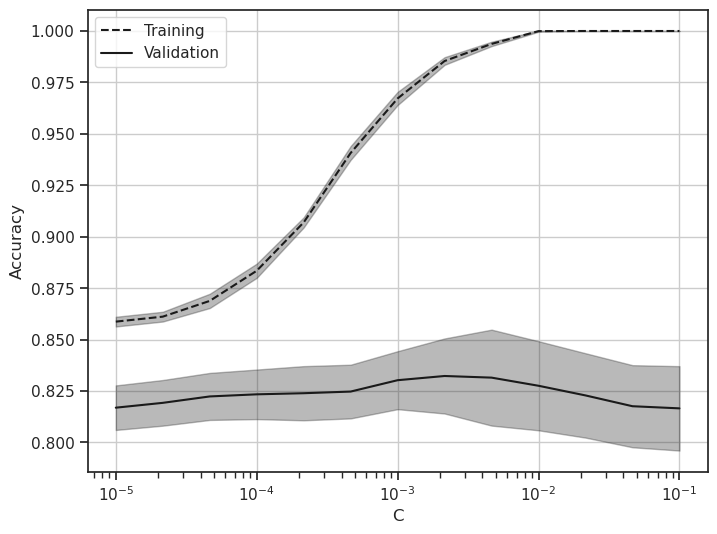

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="C", y_label="Accuracy", log_scale=True)

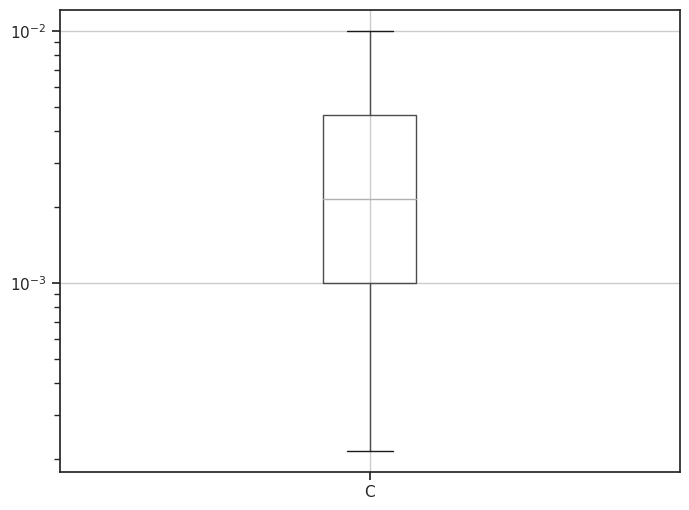

In [ ]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="C", log_scale=True)

### Confidence scores by class

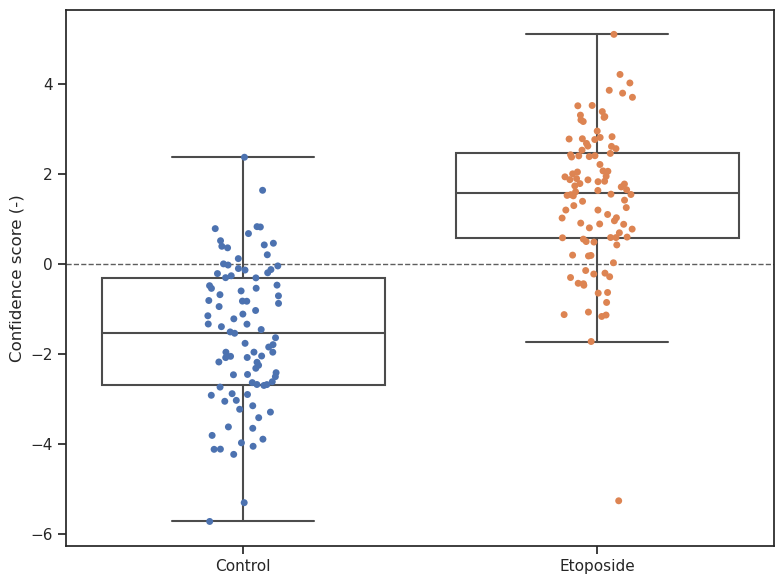

In [ ]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

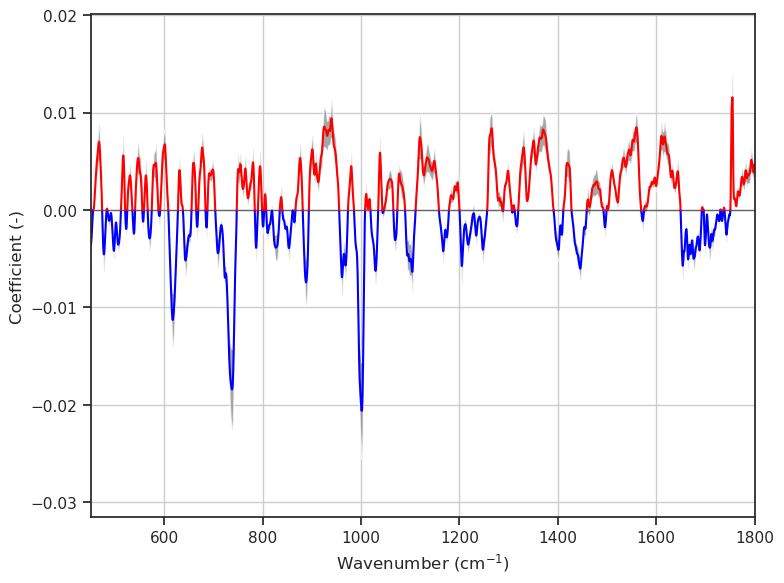

In [ ]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=0.05, min_dist=50)

### Confusion Matrix

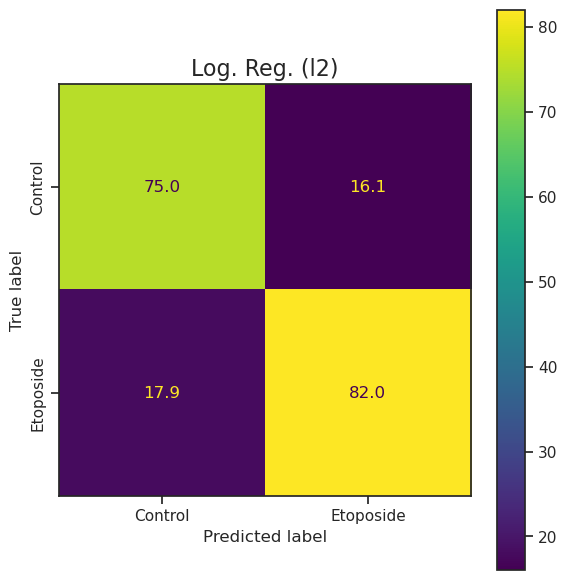

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

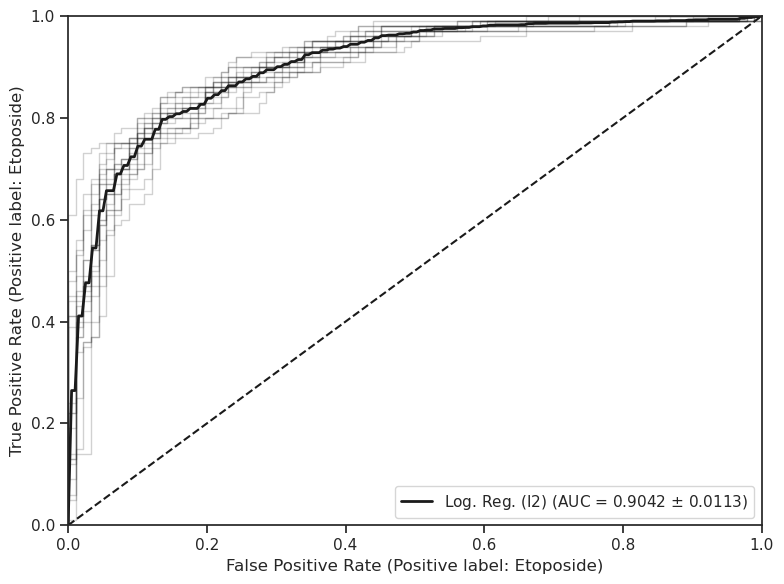

In [ ]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Support Vector Machine (l1)
### Overview

In [ ]:
current_path = results_path / "regularized_models/svm_l1/"
name = "SVM (l1)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_roc_auc  test_roc_auc  train_accuracy  test_accuracy   train_f1  \
count      20.000000     20.000000       20.000000      20.000000  20.000000   
mean        0.975013      0.946368        0.897454       0.859690   0.907468   
std         0.004679      0.007743        0.013510       0.009937   0.011803   
min         0.963103      0.931491        0.870433       0.837787   0.884317   
25%         0.971944      0.942105        0.888771       0.853374   0.899902   
50%         0.975110      0.945278        0.896620       0.861269   0.906998   
75%         0.978313      0.952047        0.909647       0.864136   0.917670   
max         0.985744      0.959240        0.920098       0.874224   0.926725   

         test_f1   fit_time  predict_time       p_value  
count  20.000000  20.000000     20.000000  2.000000e+01  
mean    0.873414   1.245459      0.010595  1.259675e-11  
std     0.010004   0.066342      0.004813  4.402060e-11  
min     0.846523   1.152244      0.003925  1.122867e-13  
25%     0.869150   1.208520      0.007251  5.252489e-13  
50%     0.873622   1.224215      0.010183  1.512144e-12  
75%     0.877979   1.257099      0.012635  4.309780e-12  
max     0.888897   1.435504      0.023734  1.989702e-10

### Validation Curve

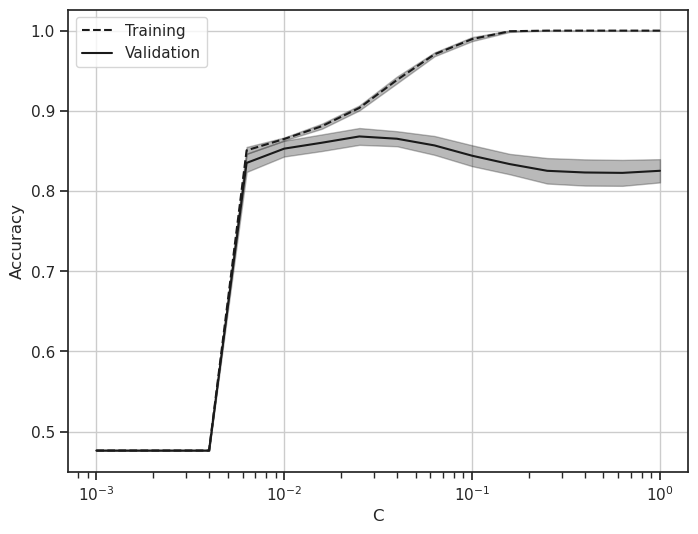

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="C", y_label="Accuracy", log_scale=True)

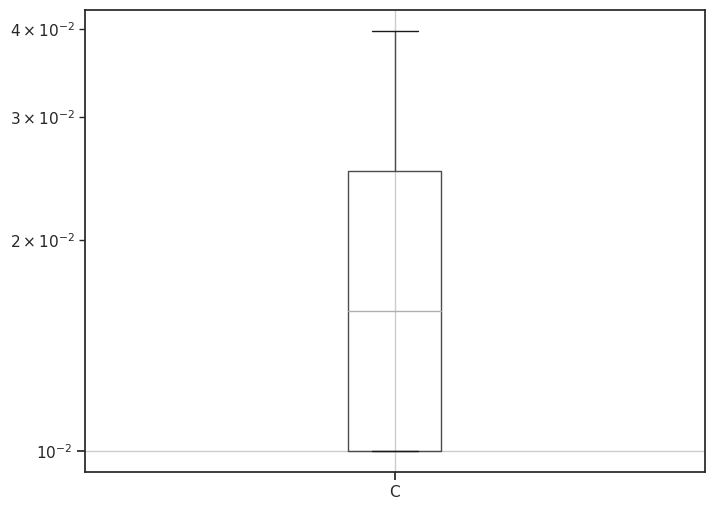

In [ ]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="C", log_scale=True)

### Confidence scores by class

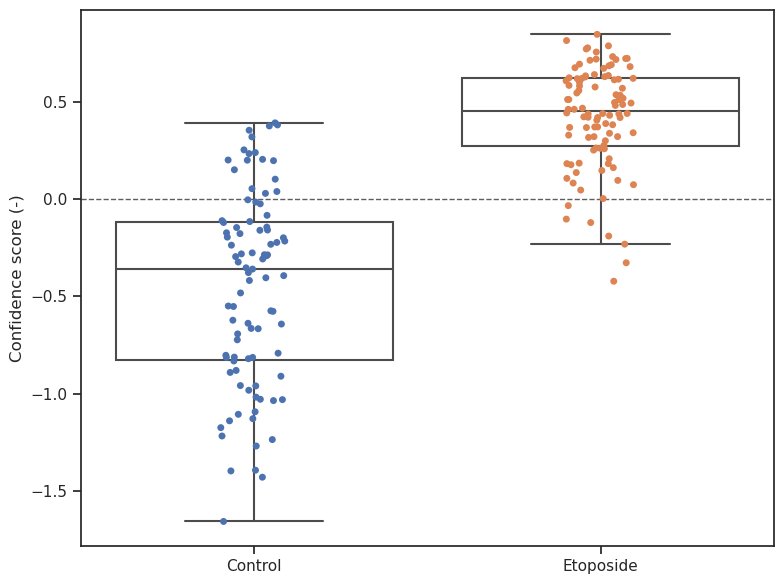

In [ ]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

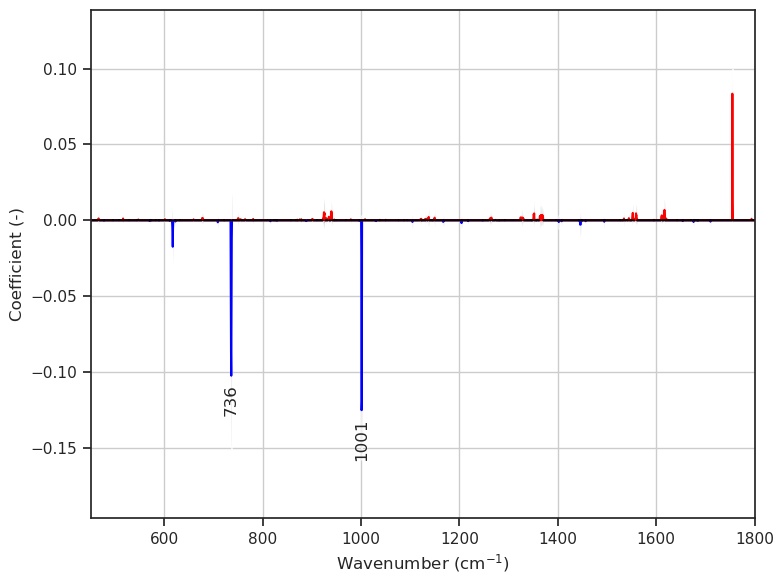

In [ ]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=0.1, min_dist=50)

### Confusion Matrix

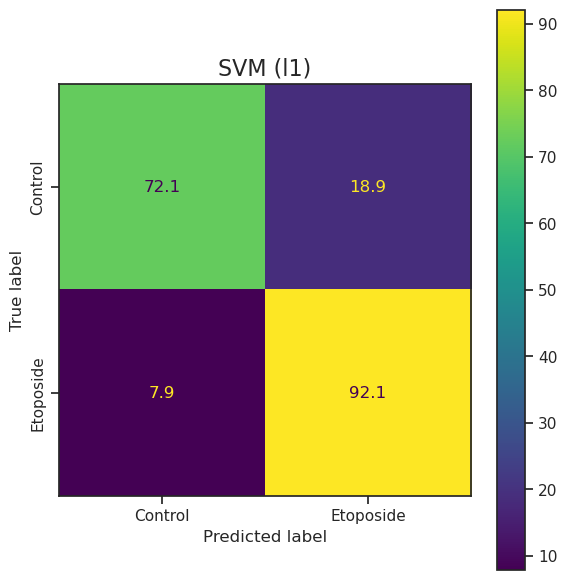

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

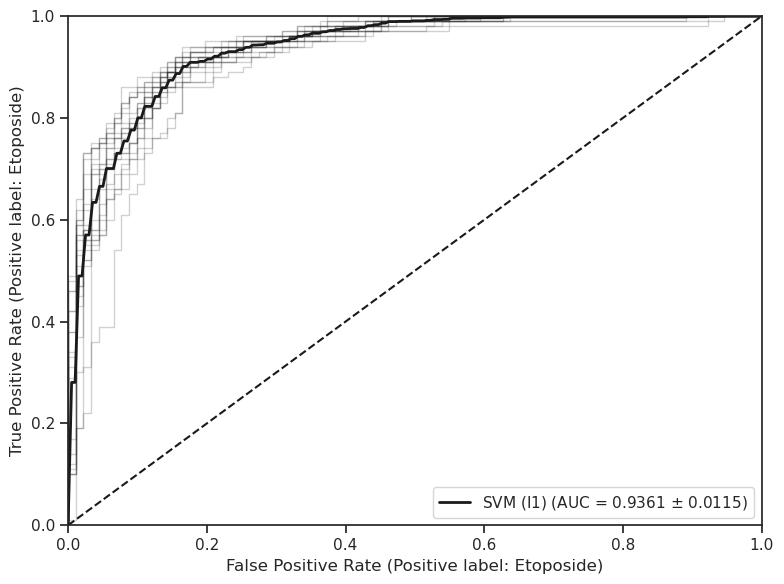

In [ ]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Support Vector Machine (l2)
### Overview

In [ ]:
current_path = results_path / "regularized_models/svm_l2/"
name = "SVM (l2)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_roc_auc  test_roc_auc  train_accuracy  test_accuracy   train_f1  \
count      20.000000     20.000000       20.000000      20.000000  20.000000   
mean        0.991830      0.909639        0.963223       0.815040   0.964636   
std         0.002662      0.011102        0.008258       0.017702   0.007995   
min         0.986870      0.889386        0.945029       0.780837   0.947181   
25%         0.989778      0.903779        0.956835       0.805061   0.958653   
50%         0.992405      0.907822        0.963988       0.811673   0.965091   
75%         0.993834      0.917003        0.967630       0.828239   0.969010   
max         0.995934      0.931140        0.980384       0.848313   0.981365   

         test_f1   fit_time  predict_time       p_value  
count  20.000000  20.000000     20.000000  2.000000e+01  
mean    0.821712   0.553758      0.010799  5.613742e-08  
std     0.017683   0.021051      0.007370  1.166871e-07  
min     0.785264   0.524294      0.003816  2.021618e-10  
25%     0.811003   0.540033      0.006468  1.806436e-09  
50%     0.820087   0.553199      0.008721  1.745483e-08  
75%     0.835761   0.559573      0.012144  3.912622e-08  
max     0.854680   0.614943      0.037336  4.859791e-07

### Validation Curve

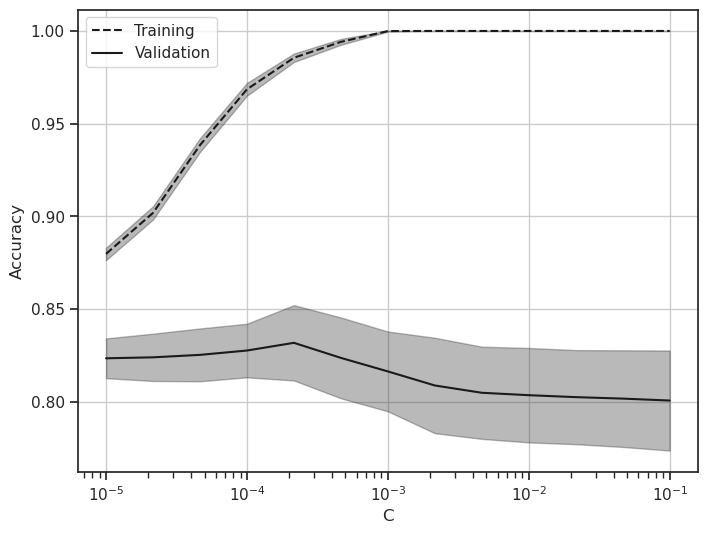

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="C", y_label="Accuracy", log_scale=True)

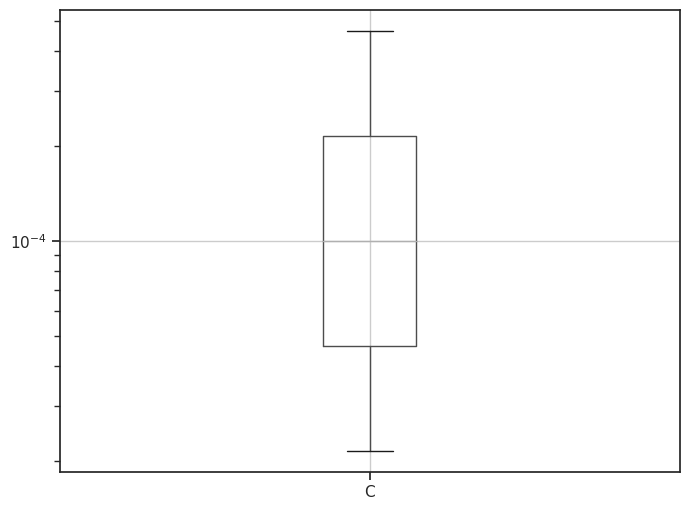

In [ ]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="C", log_scale=True)

### Confidence scores by class

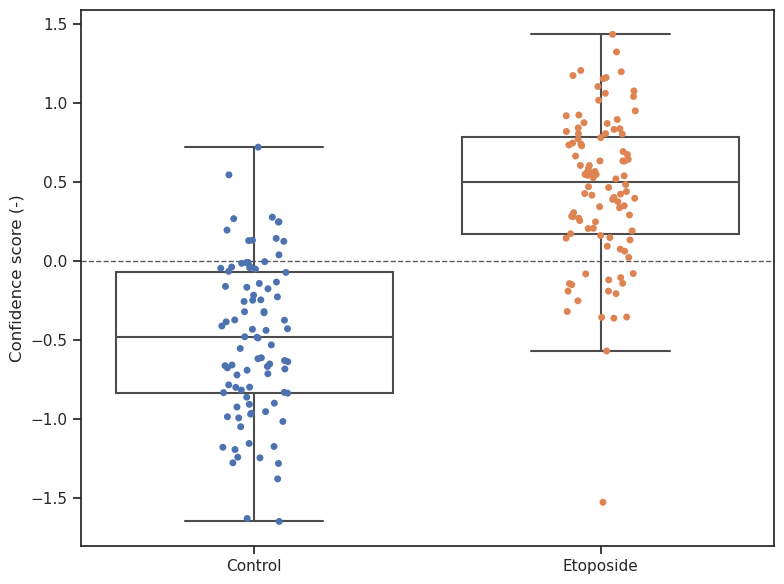

In [ ]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key)

### Model coefficients

Positive: Higher in Treated

Negative: Higher in Control

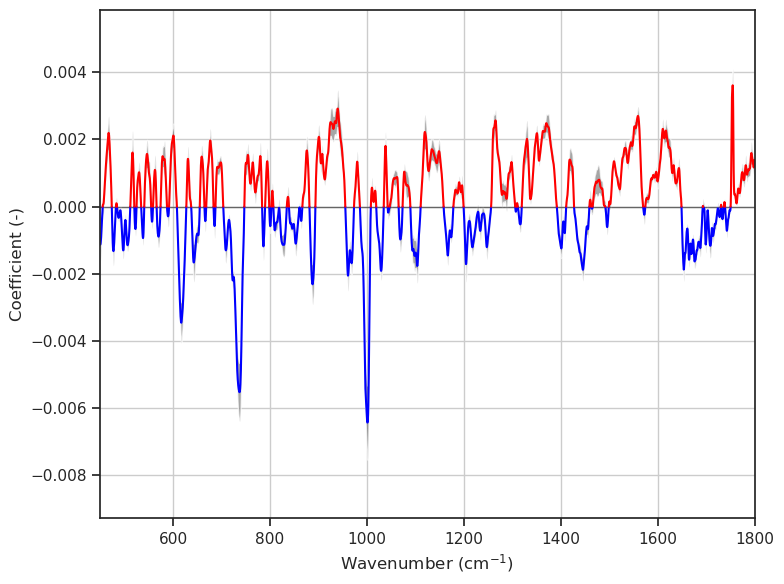

In [ ]:
coef_df = pd.read_csv(current_path / "coefficients.csv")
plot_coefs(coef_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", show_range=True, annotate=True, min_height=0.1, min_dist=50)

### Confusion Matrix

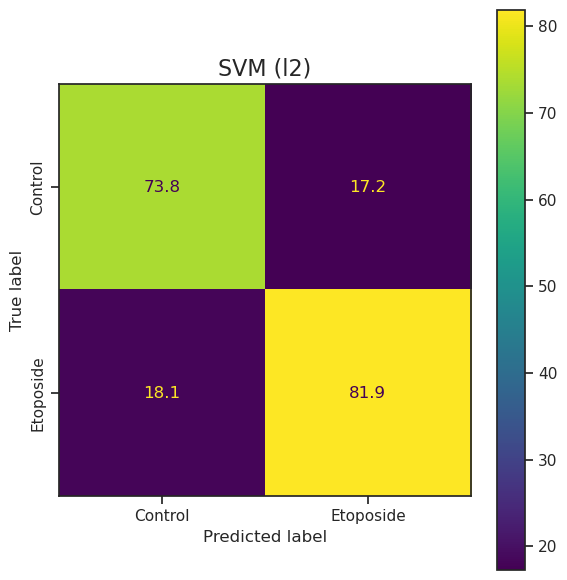

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

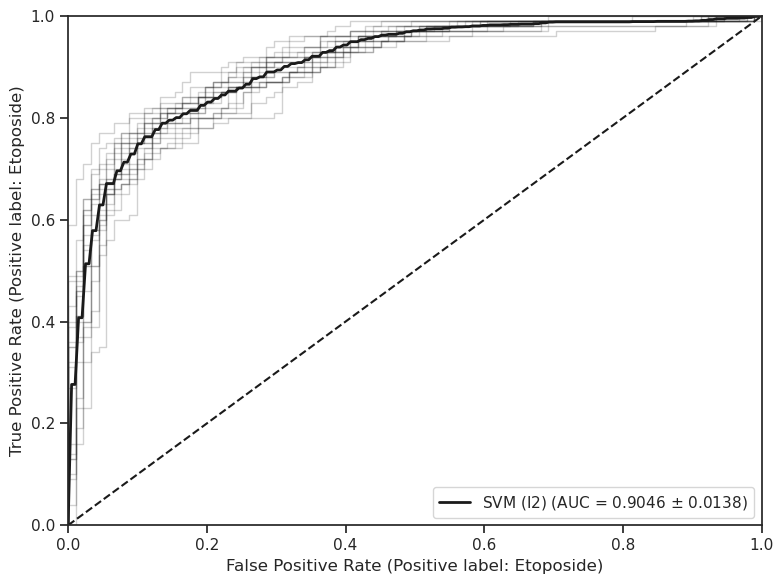

In [ ]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Comparison of Regularized Models (Logistic Regression and Linear SVM)

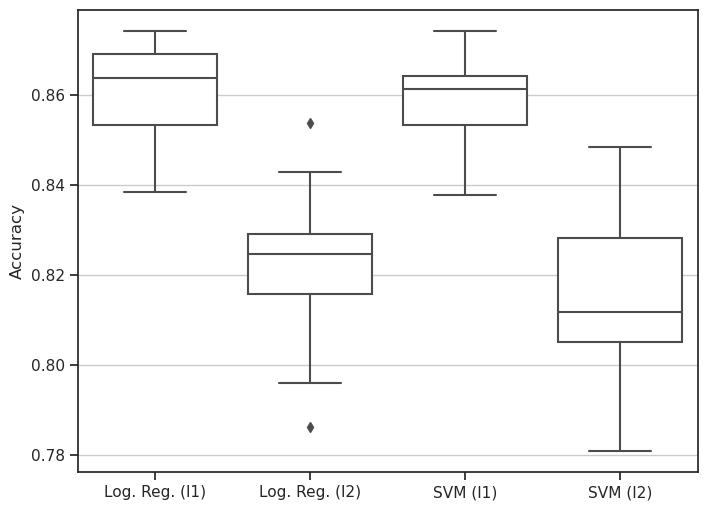

In [ ]:
boxplot_comparison(accs, ylabel="Accuracy", regex="Log. Reg.|SVM")

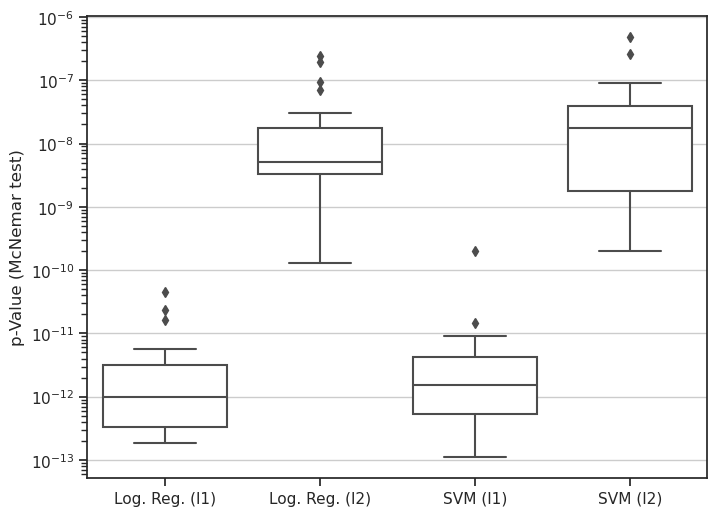

In [ ]:
boxplot_comparison(p_vals, ylabel="p-Value (McNemar test)", log_scale=True, regex="Log. Reg.|SVM")

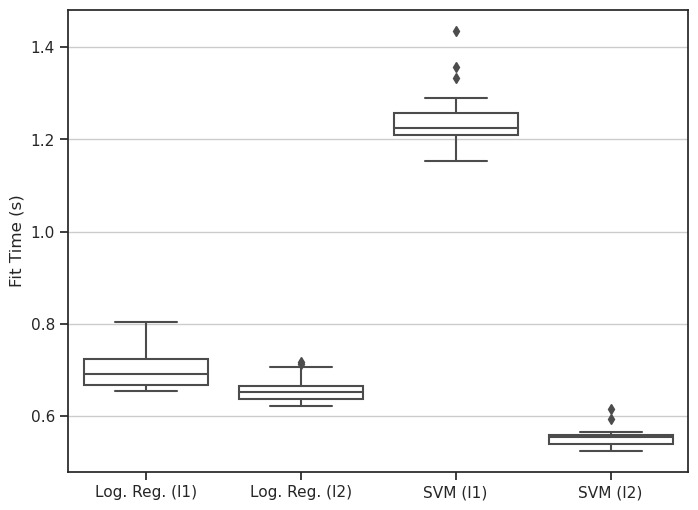

In [ ]:
boxplot_comparison(fit_times, ylabel="Fit Time (s)", regex="Log. Reg.|SVM")

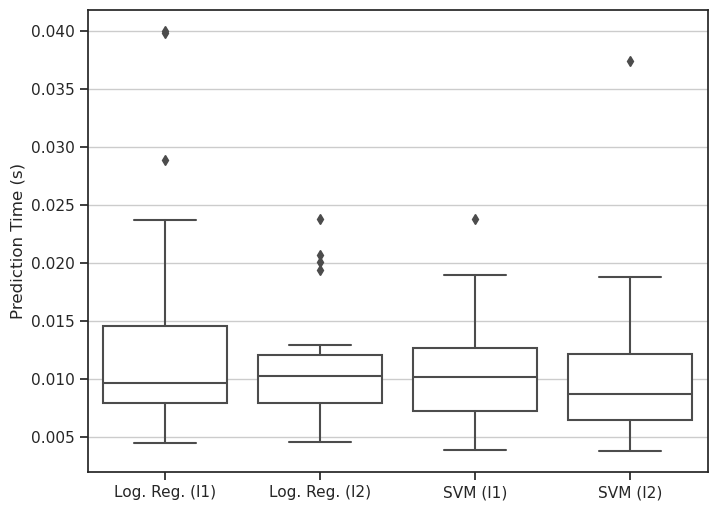

In [ ]:
boxplot_comparison(predict_times, ylabel="Prediction Time (s)", regex="Log. Reg.|SVM")

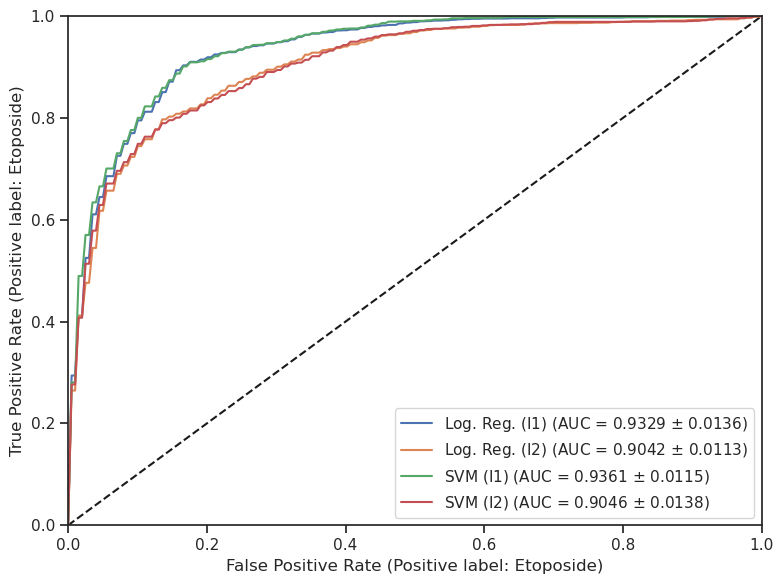

In [ ]:
plot_roc_comparison(rocs, aucs, labels=y_key, regex="Log. Reg.|SVM")

## Decision Tree
### Overview

In [ ]:
current_path = results_path / "tree_based_models/decision_tree/"
name = "Decision Tree"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_roc_auc  test_roc_auc  train_accuracy  test_accuracy   train_f1  \
count      20.000000     20.000000       20.000000      20.000000  20.000000   
mean        0.931406      0.850048        0.908437       0.837706   0.909194   
std         0.013211      0.028371        0.010359       0.027527   0.009837   
min         0.906736      0.785629        0.886103       0.759919   0.891244   
25%         0.923623      0.837774        0.902804       0.824494   0.902447   
50%         0.930968      0.847200        0.905719       0.837584   0.908573   
75%         0.941591      0.875753        0.915237       0.853171   0.915724   
max         0.954639      0.893553        0.928062       0.884615   0.927431   

         test_f1   fit_time  predict_time       p_value  
count  20.000000  20.000000     20.000000  2.000000e+01  
mean    0.839160   1.022984      0.002443  8.870809e-07  
std     0.028990   0.072267      0.000807  3.922408e-06  
min     0.752462   0.914928      0.001482  5.043242e-12  
25%     0.827254   0.968139      0.001954  2.646951e-10  
50%     0.838762   1.005081      0.002151  2.198373e-09  
75%     0.859110   1.078230      0.002689  1.441333e-08  
max     0.886982   1.157958      0.004388  1.755139e-05

### Validation Curve

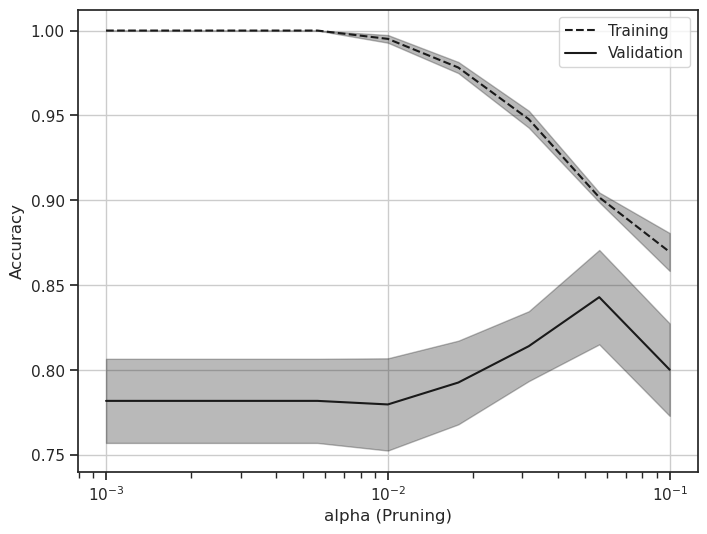

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="alpha (Pruning)", y_label="Accuracy", log_scale=True)

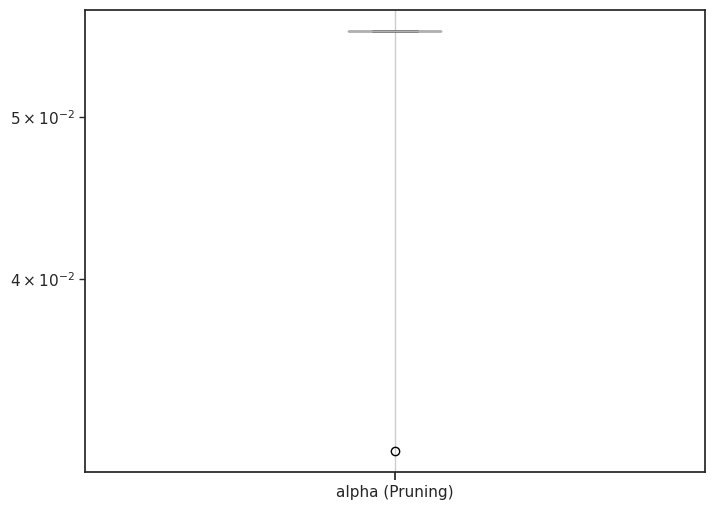

In [ ]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="alpha (Pruning)", log_scale=True)

### Confidence scores by class

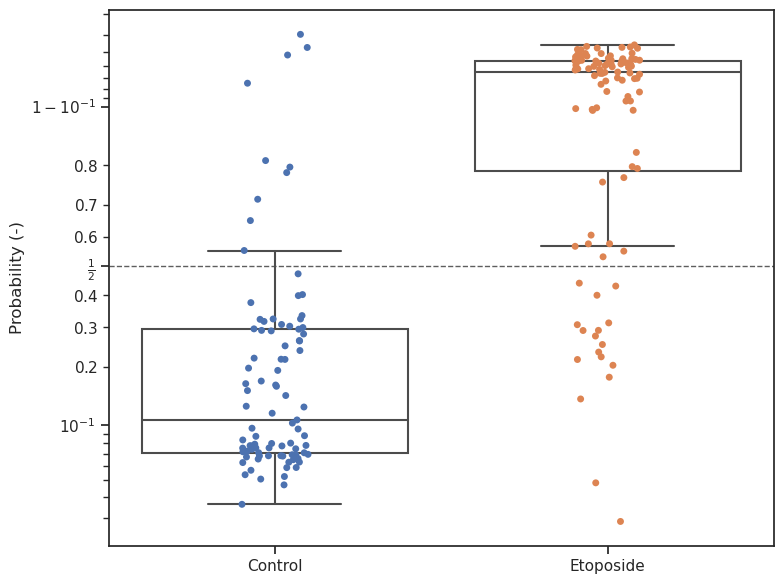

In [ ]:
conf_score_df = pd.read_csv(current_path / "probabilities.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key, scale="logit")

### Tree

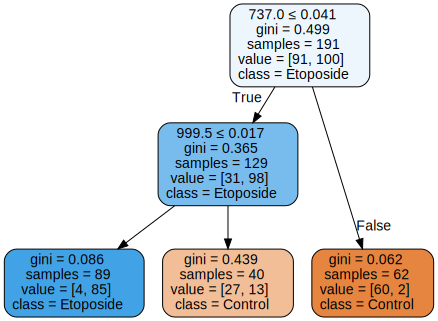

In [ ]:
graphviz.Source.from_file(current_path / "tree.dot")

### Confusion Matrix

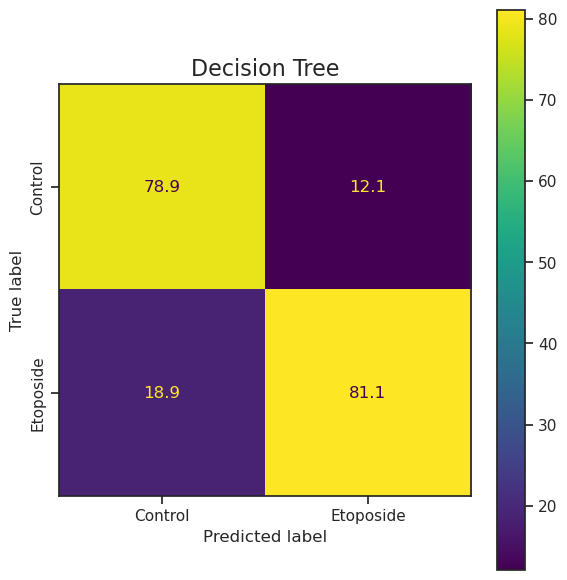

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

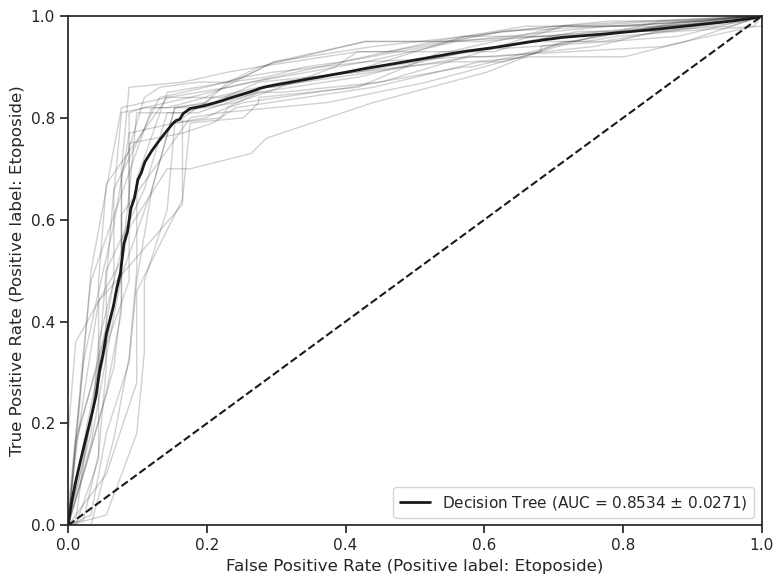

In [ ]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

## Random Forest
### Overview

In [ ]:
current_path = results_path / "tree_based_models/random_forest/"
name = "Random Forest"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_roc_auc  test_roc_auc  train_accuracy  test_accuracy   train_f1  \
count      20.000000     20.000000       20.000000      20.000000  20.000000   
mean        0.984701      0.943322        0.929911       0.855513   0.932443   
std         0.001131      0.006620        0.006369       0.014004   0.006251   
min         0.982644      0.929532        0.914921       0.822267   0.917617   
25%         0.983828      0.939788        0.926389       0.846795   0.928965   
50%         0.984733      0.943494        0.930633       0.858165   0.932922   
75%         0.985312      0.947997        0.934531       0.863866   0.936649   
max         0.987293      0.957222        0.939775       0.879352   0.942231   

         test_f1   fit_time  predict_time       p_value  
count  20.000000  20.000000     20.000000  2.000000e+01  
mean    0.860259  38.836451      0.003266  7.062229e-10  
std     0.015173   6.583746      0.001891  2.034752e-09  
min     0.826785  26.134275      0.000962  2.398041e-12  
25%     0.850216  34.207850      0.002067  4.213448e-11  
50%     0.864270  36.382549      0.002768  6.526312e-11  
75%     0.867534  44.977195      0.003873  4.917648e-10  
max     0.882954  49.763657      0.008752  9.166126e-09

### Validation Curve

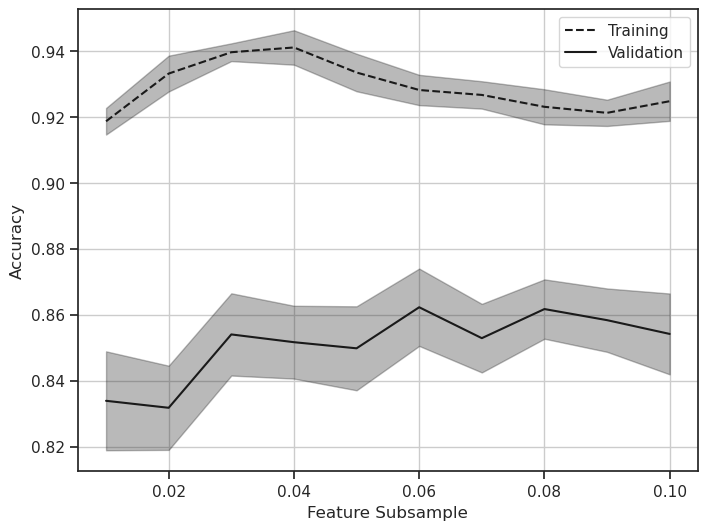

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="Feature Subsample", y_label="Accuracy")

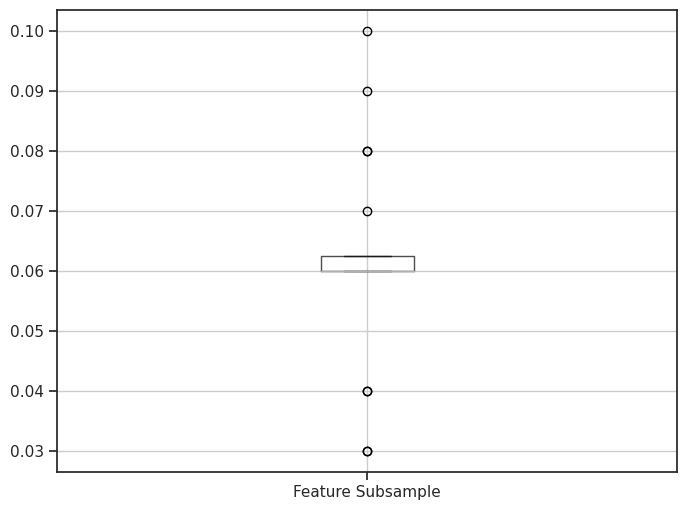

In [ ]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="Feature Subsample")

### Confidence scores by class

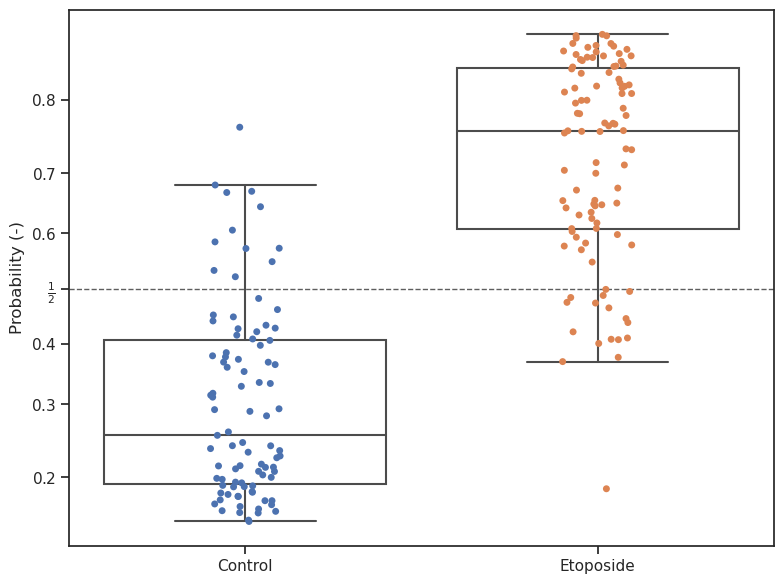

In [ ]:
conf_score_df = pd.read_csv(current_path / "probabilities.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key, scale="logit")

### Confusion Matrix

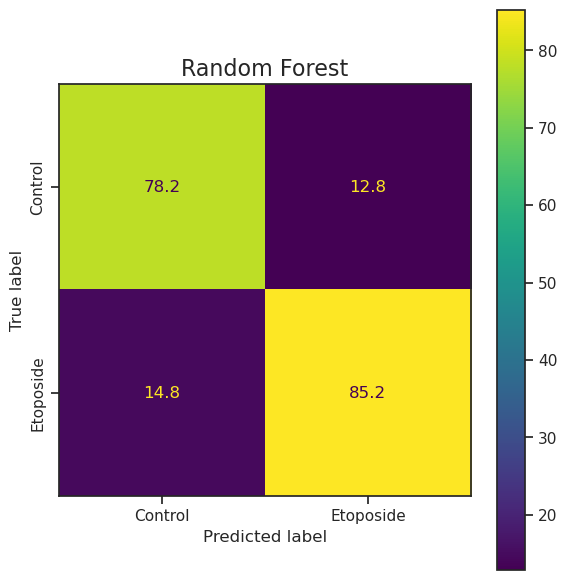

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

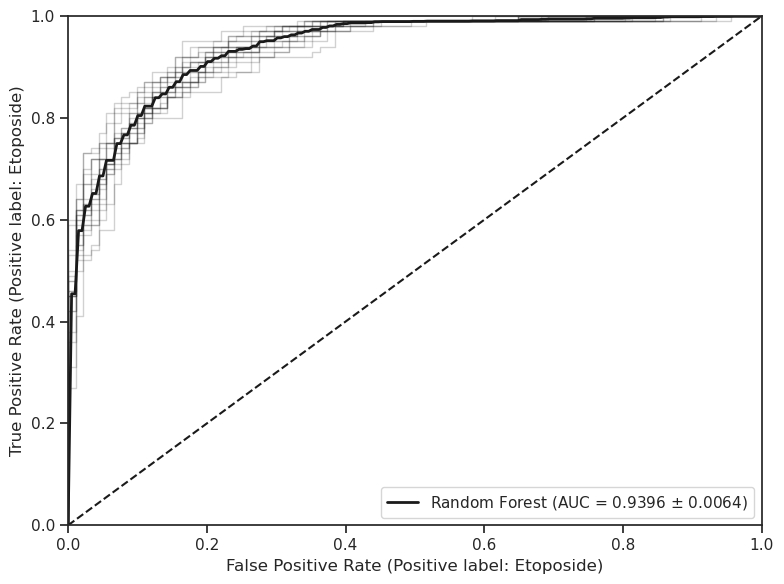

In [ ]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

### Explainable AI - SHAP

In [ ]:
shap_base_vals = np.genfromtxt(current_path / "shap/base_values.csv")
shap_vals = np.genfromtxt(current_path / "shap/values.csv", delimiter=",")
shap_data = np.genfromtxt(current_path / "shap/data.csv", delimiter=",")
shap_features = np.genfromtxt(current_path / "shap/feature_names.csv")
explanation = shap.Explanation(values=shap_vals, base_values=shap_base_vals, data=shap_data)

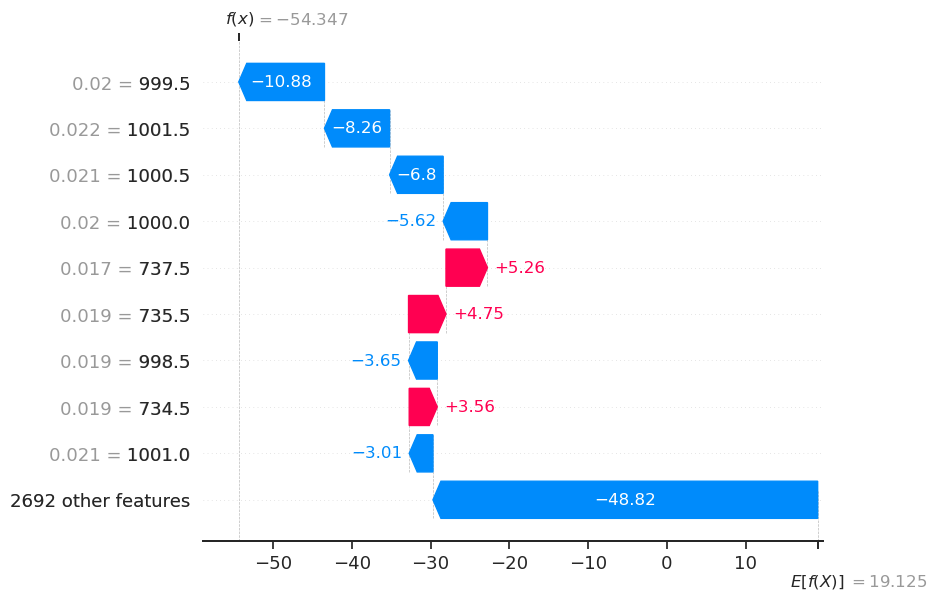

In [ ]:
first_expl = explanation[0]
first_expl.feature_names = shap_features.astype(str)
shap.waterfall_plot(first_expl)

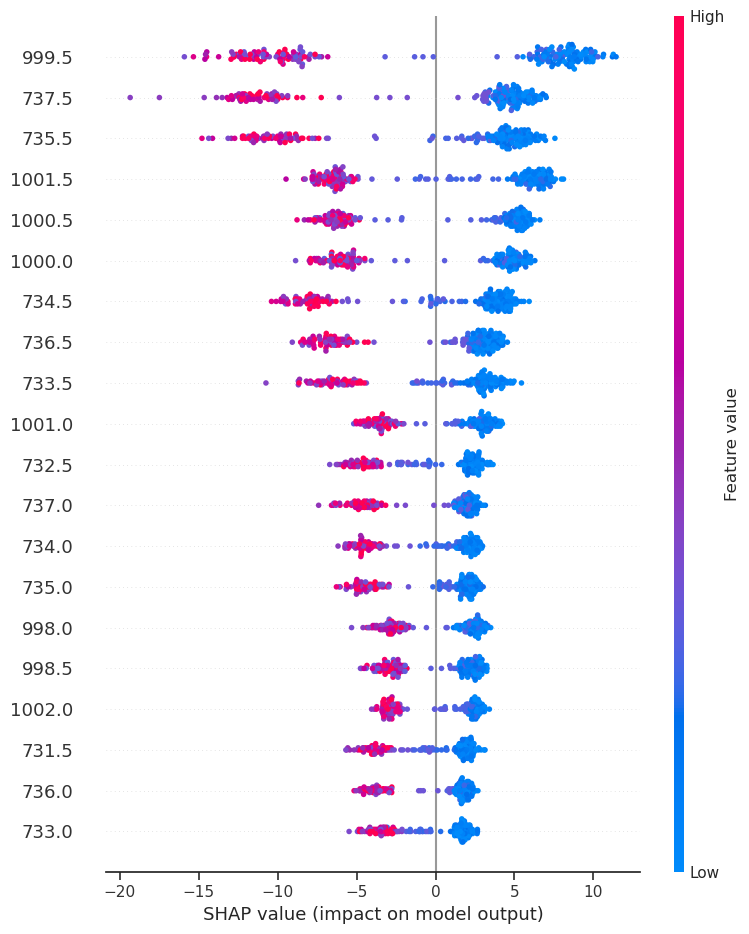

In [ ]:
shap.summary_plot(explanation, feature_names=shap_features)

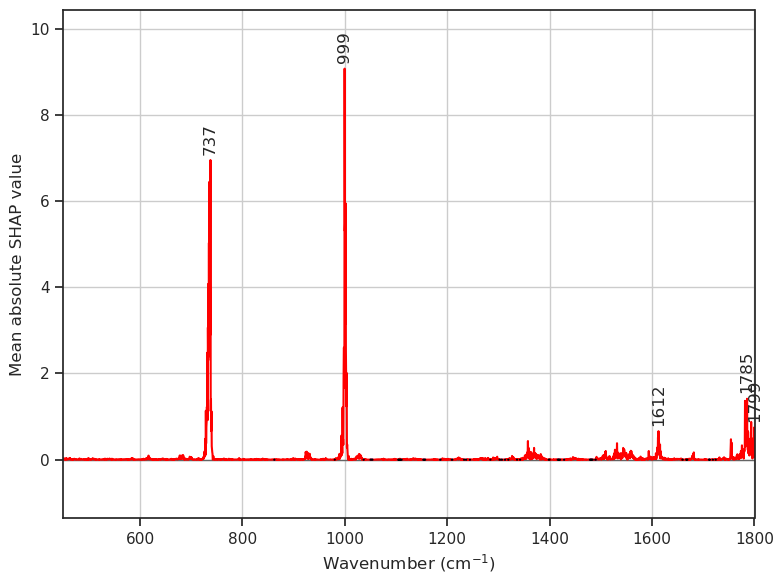

In [ ]:
shap_val_df = pd.Series(data=np.mean(np.absolute(shap_vals), axis=0), index=shap_features)

plot_coefs(shap_val_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", ylabel="Mean absolute SHAP value", annotate=True, min_height=0.5)

## Gradient Boosted Trees
### Overview

In [ ]:
current_path = results_path / "tree_based_models/gbdt/"
name = "Gradient-boosted Trees"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

train_roc_auc  test_roc_auc  train_accuracy  test_accuracy  train_f1  \
count           20.0     20.000000            20.0      20.000000      20.0   
mean             1.0      0.935763             1.0       0.851350       1.0   
std              0.0      0.009529             0.0       0.015448       0.0   
min              1.0      0.915994             1.0       0.827395       1.0   
25%              1.0      0.927420             1.0       0.841397       1.0   
50%              1.0      0.937047             1.0       0.850607       1.0   
75%              1.0      0.943984             1.0       0.865587       1.0   
max              1.0      0.947047             1.0       0.874764       1.0   

         test_f1   fit_time  predict_time       p_value  
count  20.000000  20.000000     20.000000  2.000000e+01  
mean    0.857257  37.566686      0.002188  3.658844e-10  
std     0.013251   7.316683      0.001844  4.061536e-10  
min     0.838211  20.595923      0.000484  7.302771e-12  
25%     0.847086  32.524376      0.001561  2.968969e-11  
50%     0.852710  38.539301      0.001845  2.019661e-10  
75%     0.869345  43.504038      0.002166  7.013392e-10  
max     0.877236  46.734750      0.009548  1.230482e-09

### Validation Curve

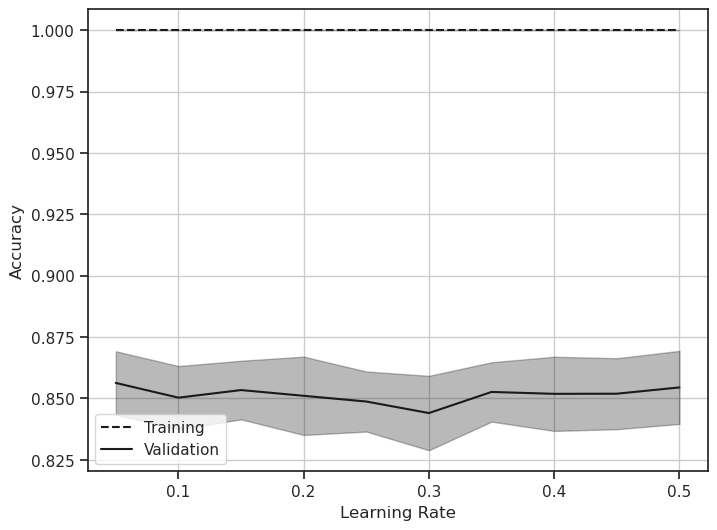

In [ ]:
cv_df = pd.read_csv(current_path / "cv_results.csv")

plot_val_curves(cv_df, x_labels="Learning Rate", y_label="Accuracy")

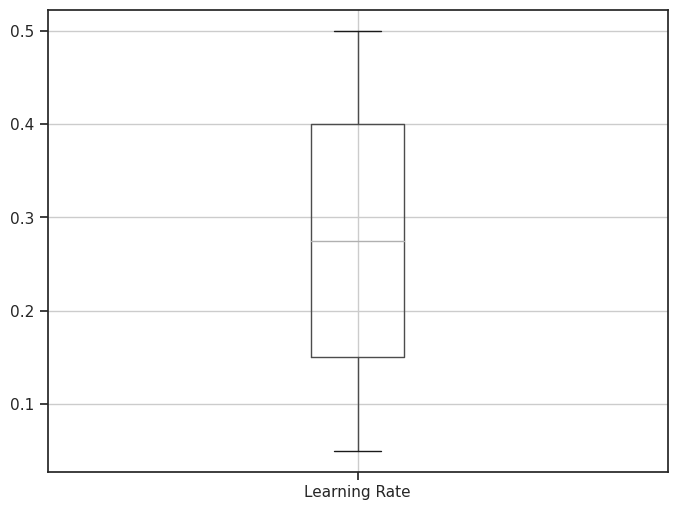

In [ ]:
param_df = pd.read_csv(current_path / "param_results.csv")
plot_params(param_df, labels="Learning Rate")

### Confidence scores by class

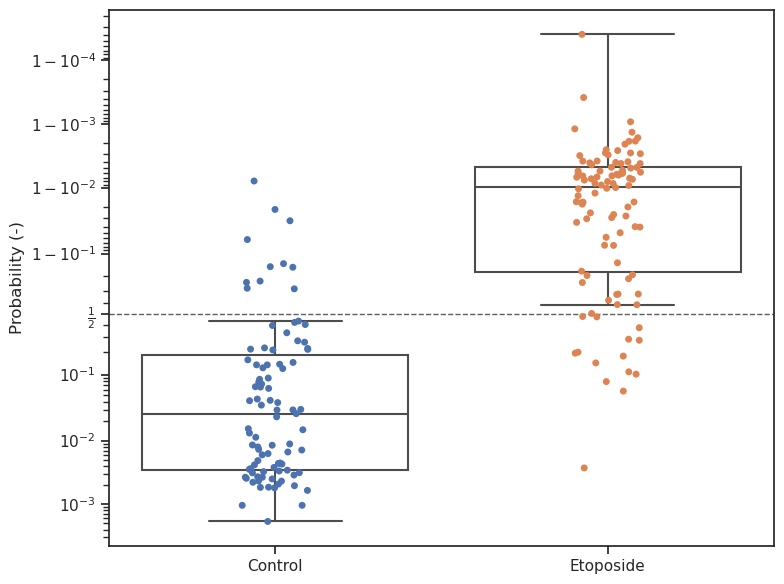

In [ ]:
conf_score_df = pd.read_csv(current_path / "probabilities.csv", header=None)
plot_confidence_scores(conf_score_df, y_key[y], y_key, scale="logit")

### Confusion Matrix

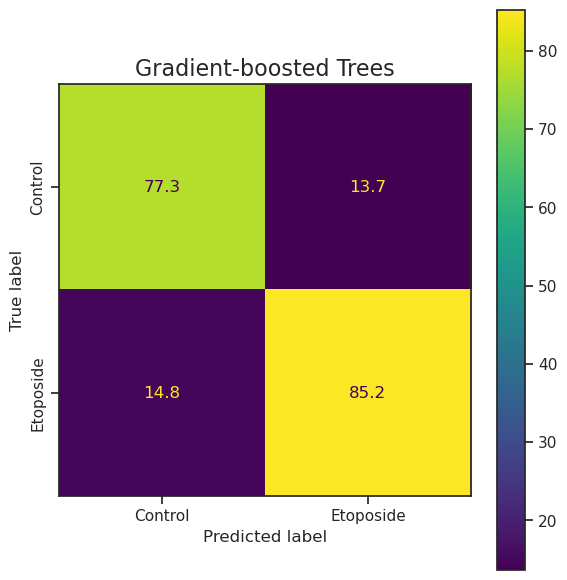

In [ ]:
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)
plot_confusion_matrix(pred_df, y, y_key, name)

### ROC Curve

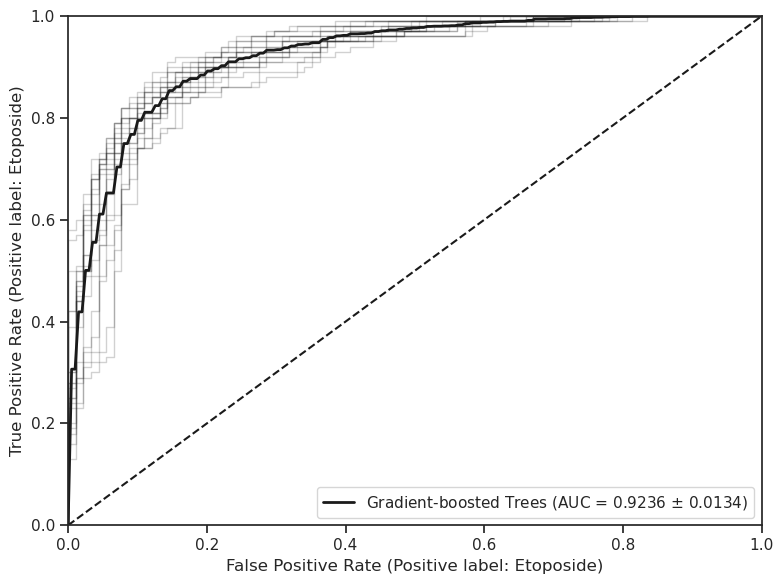

In [ ]:
roc, auc = plot_roc_curve(conf_score_df, y, y_key, name)

rocs[name] = roc
aucs[name] = auc

### Explainable AI - SHAP

In [ ]:
shap_base_vals = np.genfromtxt(current_path / "shap/base_values.csv")
shap_vals = np.genfromtxt(current_path / "shap/values.csv", delimiter=",")
shap_data = np.genfromtxt(current_path / "shap/data.csv", delimiter=",")
shap_features = np.genfromtxt(current_path / "shap/feature_names.csv")
explanation = shap.Explanation(values=shap_vals, base_values=shap_base_vals, data=shap_data)

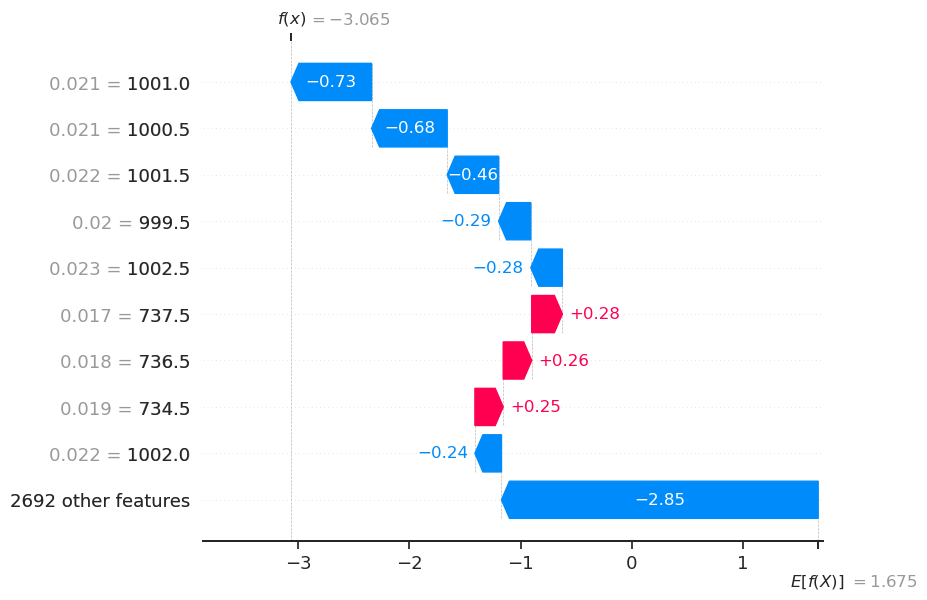

In [ ]:
first_expl = explanation[0]
first_expl.feature_names = shap_features.astype(str)
shap.waterfall_plot(first_expl)

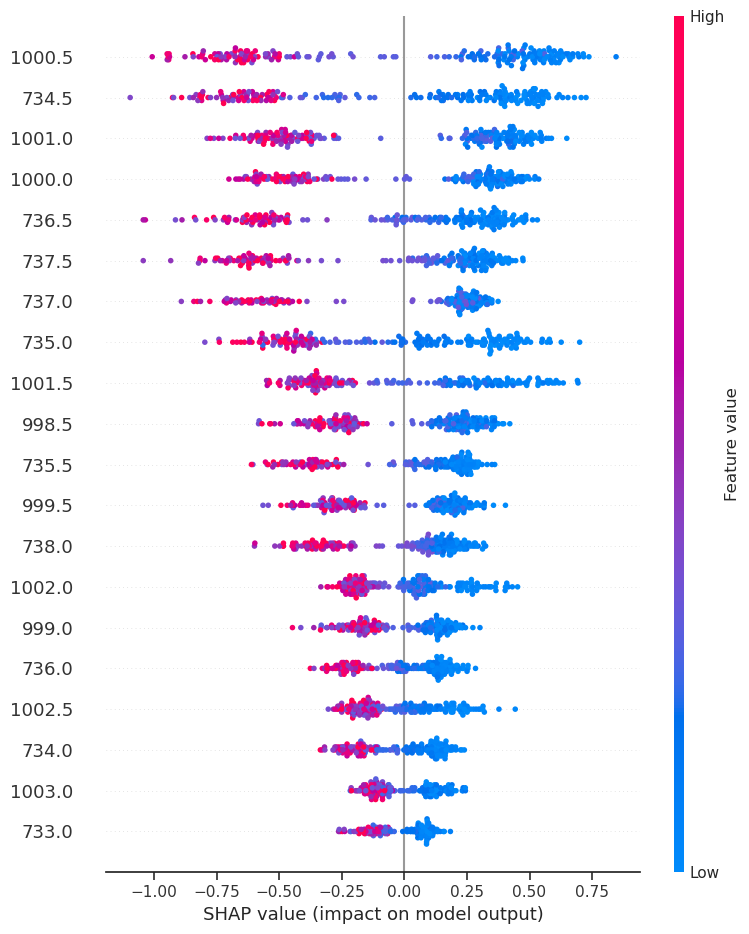

In [ ]:
shap.summary_plot(explanation, feature_names=shap_features)

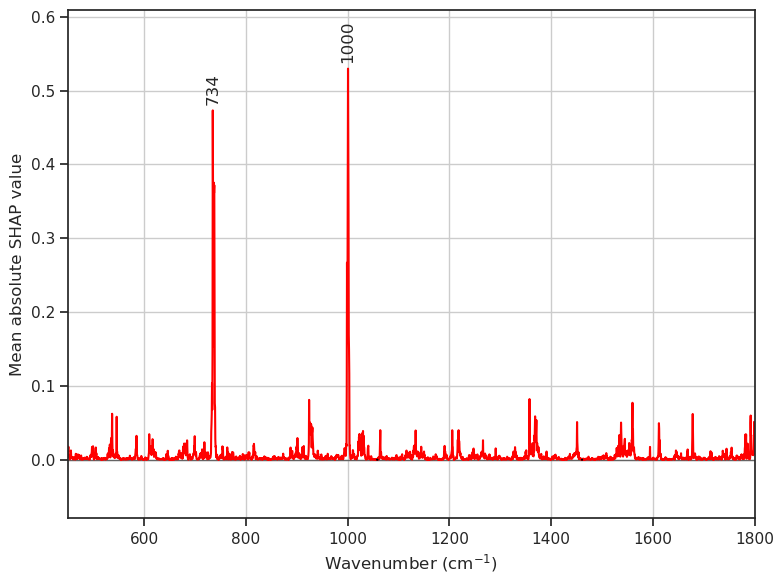

In [ ]:
shap_val_df = pd.Series(data=np.mean(np.absolute(shap_vals), axis=0), index=shap_features)

plot_coefs(shap_val_df, xlabel="Wavenumber ($\mathregular{cm^{-1}}$)", ylabel="Mean absolute SHAP value", annotate=True, min_height=0.1)

## Comparison of Tree-based Models

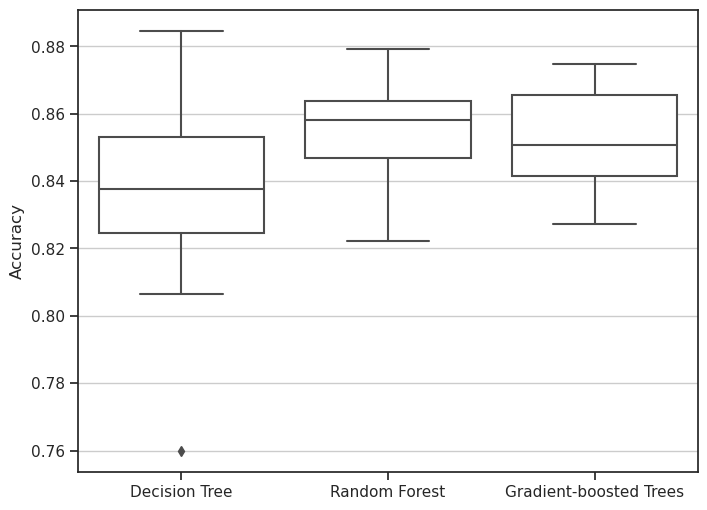

In [ ]:
boxplot_comparison(accs, ylabel="Accuracy", regex="Tree|Forest")

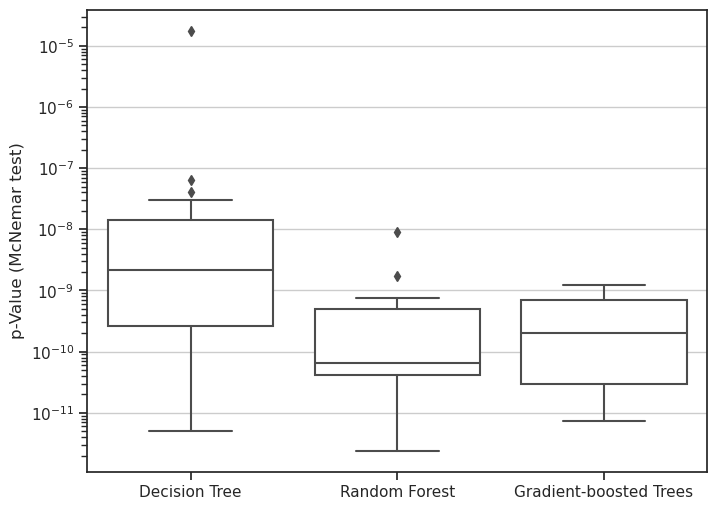

In [ ]:
boxplot_comparison(p_vals, ylabel="p-Value (McNemar test)", log_scale=True, regex="Tree|Forest")

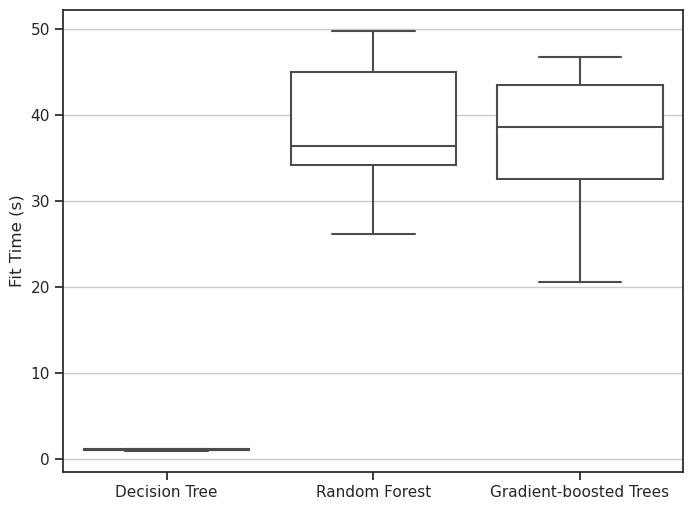

In [ ]:
boxplot_comparison(fit_times, ylabel="Fit Time (s)", regex="Tree|Forest")

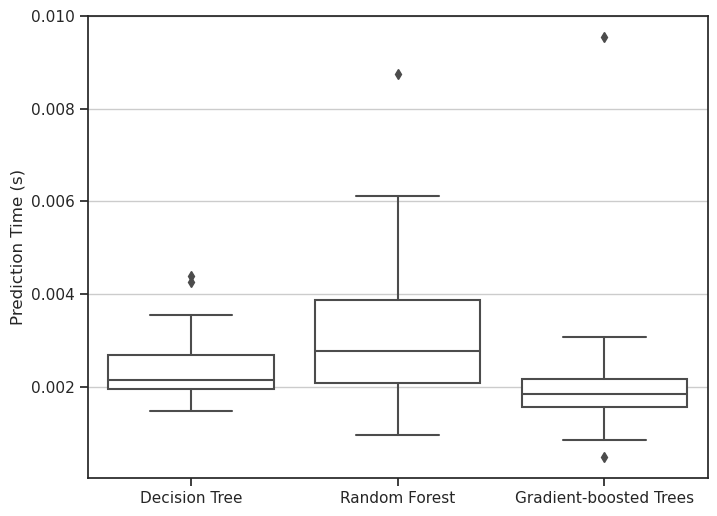

In [ ]:
boxplot_comparison(predict_times, ylabel="Prediction Time (s)", regex="Tree|Forest")

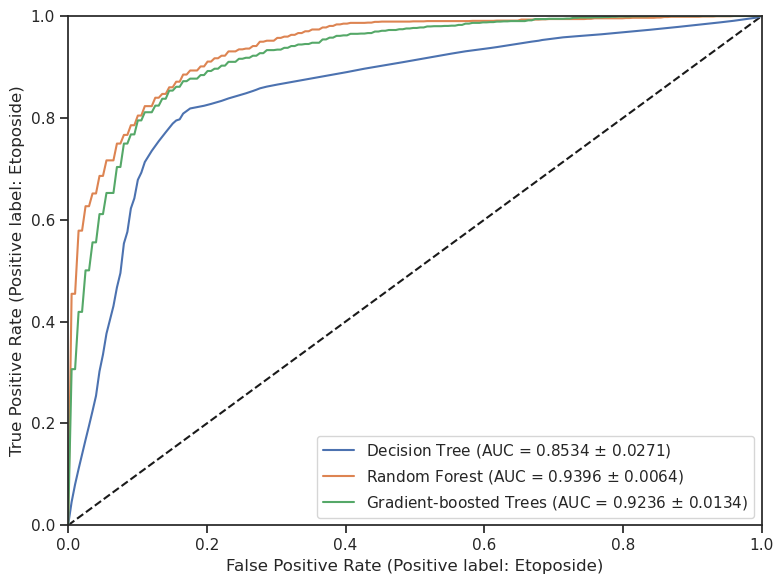

In [ ]:
plot_roc_comparison(rocs, aucs, labels=y_key, regex="Tree|Forest")

## Overall Comparison

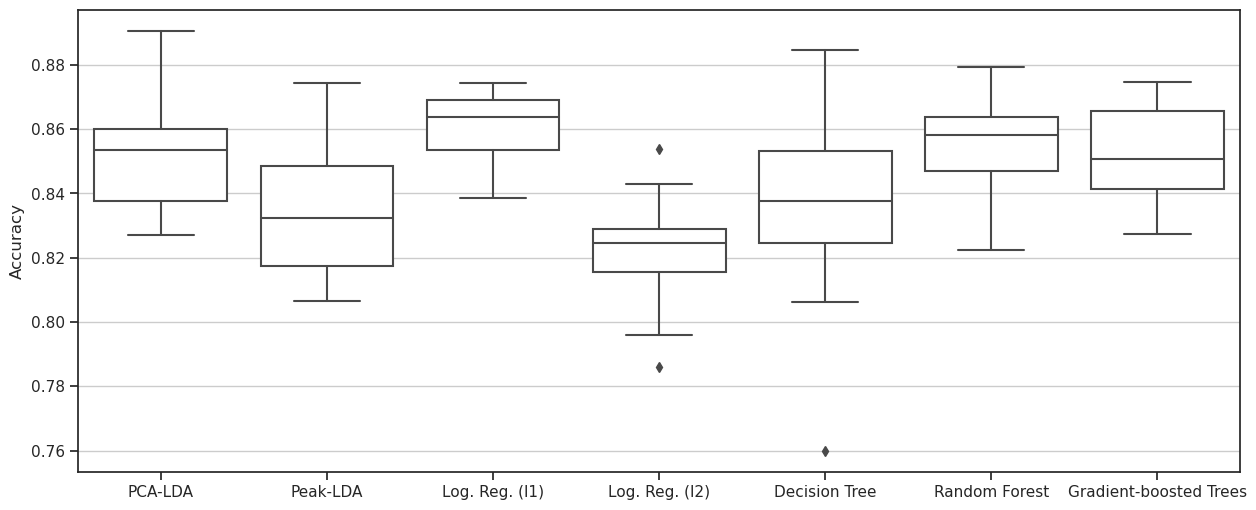

In [ ]:
boxplot_comparison(accs, ylabel="Accuracy", regex="PCA|Peak|Log. Reg|Tree|Forest", figsize=(15, 6))

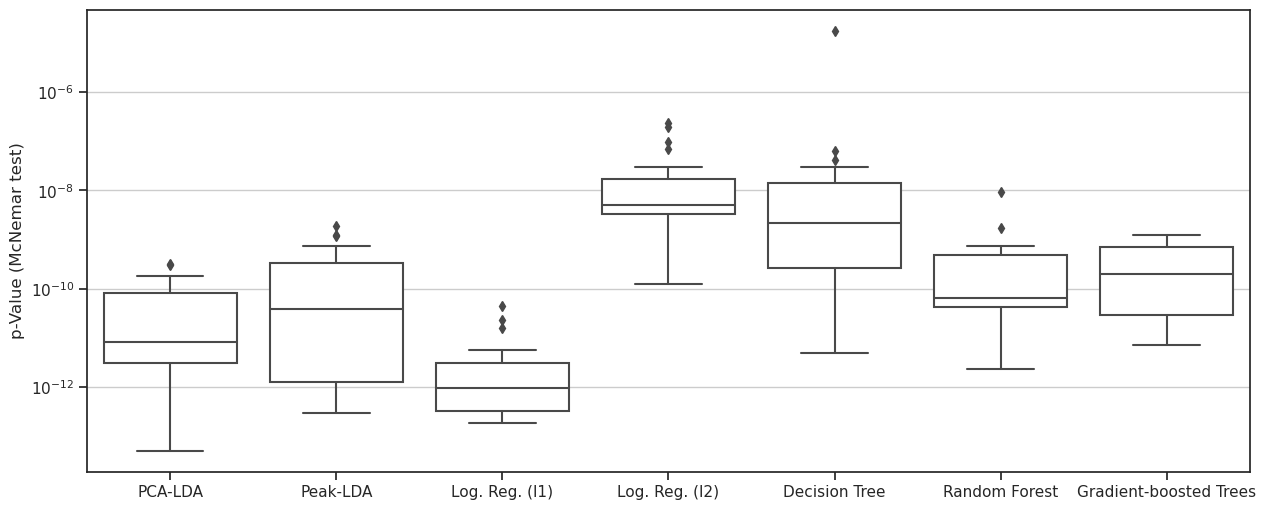

In [ ]:
boxplot_comparison(p_vals, ylabel="p-Value (McNemar test)", log_scale=True, regex="PCA|Peak|Log. Reg|Tree|Forest", figsize=(15, 6))

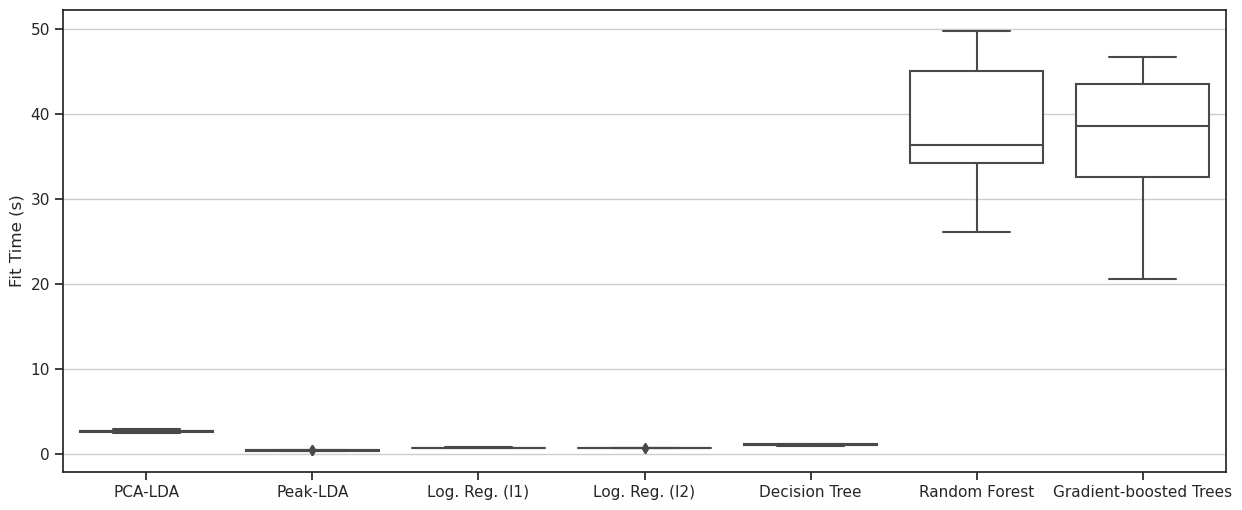

In [ ]:
boxplot_comparison(fit_times, ylabel="Fit Time (s)", regex="PCA|Peak|Log. Reg|Tree|Forest", figsize=(15, 6))

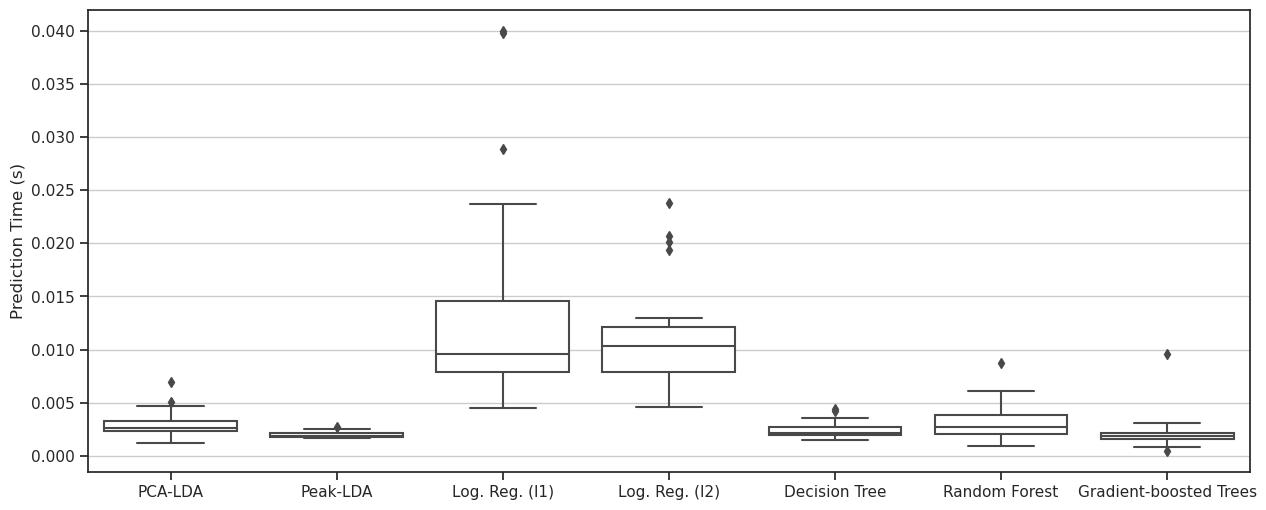

In [ ]:
boxplot_comparison(predict_times, ylabel="Prediction Time (s)", regex="PCA|Peak|Log. Reg|Tree|Forest", figsize=(15, 6))

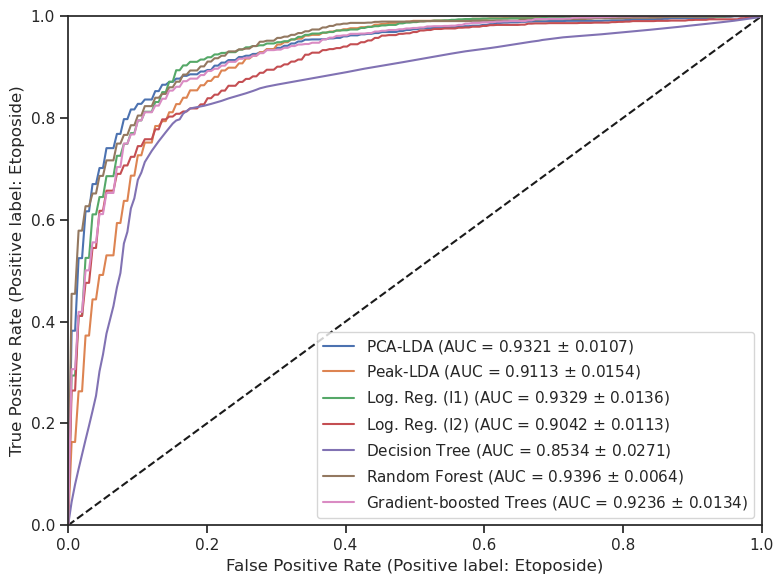

In [ ]:
plot_roc_comparison(rocs, aucs, labels=y_key, regex="PCA|Peak|Log. Reg|Tree|Forest")